<a href="https://colab.research.google.com/github/ganeshgaurav/Dissertation/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web scraping

In [ ]:
!pip install requests beautifulsoup4 pandas

### Webscraping from Cricbuzz

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

def get_ipl_match_results(url):
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch data for URL: {url}. Status code: {response.status_code}")
        return []

    soup = BeautifulSoup(response.content, "html.parser")
    match_cards = soup.find_all("div", class_="cb-col-75 cb-col")
    if not match_cards:
        print(f"No match cards found for URL: {url}.")
        return []

    data = []
    for card in match_cards:
        match_data = {}

        match_details = card.find("a", class_="text-hvr-underline")
        if not match_details:
            print(f"No match details found.")
            continue
        match_data["Match Details"] = match_details.text.strip()

        match_venue = card.find("div", class_="text-gray")
        if not match_venue:
            print(f"No match venue found.")
            continue
        match_data["Venue"] = match_venue.text.strip()

        match_result = card.find("a", class_="cb-text-complete")
        if not match_result:
            print(f"No match result found.")
            continue
        match_data["Result"] = match_result.text.strip()

        # Extracting match time from the text
        match_time_span = card.find("div", class_="cb-col-40 cb-col cb-srs-mtchs-tm")
        if not match_time_span:
            print(f"No match time span found.")
            continue
        match_time_text = match_time_span.text.strip()
        match_time_match = re.search(r'(\d{1,2}:\d{2} (?:AM|PM))', match_time_text)
        if match_time_match:
            match_data["Time"] = match_time_match.group(1)
        else:
            print(f"No match time found.")
            continue

        data.append(match_data)
    return data

# Define URLs for each IPL season
urls = {
    "IPL 2015": "https://www.cricbuzz.com/cricket-series/2330/indian-premier-league-2015/matches",
    "IPL 2016": "https://www.cricbuzz.com/cricket-series/2430/indian-premier-league-2016/matches",
    "IPL 2017": "https://www.cricbuzz.com/cricket-series/2568/indian-premier-league-2017/matches",
    "IPL 2018": "https://www.cricbuzz.com/cricket-series/2676/indian-premier-league-2018/matches",
    "IPL 2019": "https://www.cricbuzz.com/cricket-series/2810/indian-premier-league-2019/matches",
    "IPL 2020": "https://www.cricbuzz.com/cricket-series/3130/indian-premier-league-2020/matches",
    "IPL 2021": "https://www.cricbuzz.com/cricket-series/3472/indian-premier-league-2021/matches",
    "IPL 2022": "https://www.cricbuzz.com/cricket-series/4061/indian-premier-league-2022/matches",
    "IPL 2023": "https://www.cricbuzz.com/cricket-series/5945/indian-premier-league-2023/matches",
    "IPL 2024": "https://www.cricbuzz.com/cricket-series/7607/indian-premier-league-2024/matches",
    # Add URLs for other IPL seasons here
}

# Scrape match results for each IPL season
all_match_results = []
for season, url in urls.items():
    print(f"Scraping match results for {season}...")
    season_match_results = get_ipl_match_results(url)
    all_match_results.extend(season_match_results)

# Convert data to DataFrame
df_match_results = pd.DataFrame(all_match_results)

# Save match results to CSV file
df_match_results.to_csv("ipl_match_results_cricbuzz.csv", index=False)

print("Match results saved successfully.")


Scraping match results for IPL 2015...
Scraping match results for IPL 2016...
Scraping match results for IPL 2017...
Scraping match results for IPL 2018...
Scraping match results for IPL 2019...
Scraping match results for IPL 2020...
Scraping match results for IPL 2021...
Scraping match results for IPL 2022...
Scraping match results for IPL 2023...
Scraping match results for IPL 2024...
Match results saved successfully.


### Abbreviated team names

In [ ]:
team_names_mapping = {
    "KOLKATA KNIGHT RIDERS": "KKR",
    "MUMBAI INDIANS": "MI",
    "CHENNAI SUPER KINGS": "CSK",
    "DELHI CAPITALS": "DC",
    "PUNJAB KINGS": "PK",
    "RAJASTHAN ROYALS": "RR",
    "SUNRISERS HYDERABAD": "SRH",
    "ROYAL CHALLENGERS BENGALURU": "RCB",
    "KINGS XI PUNJAB": "KXIP",  # Also updating this name
    "DELHI DAREDEVILS": "DC",     # Also updating this name
    "GUJARAT TITANS": "GT",
    "LUCKNOW SUPER GIANTS": "LSG",
    "RISING PUNE SUPERGIANT": "RPS",
    "GUJARAT LIONS": "GL",
}

# Function to replace team names with abbreviations
def replace_team_names(match_results):
    for index, row in match_results.iterrows():
        match_details = row["Match Details"]
        for full_name, abbreviation in team_names_mapping.items():
            match_details = re.sub(
                r'\b' + re.escape(full_name) + r'\b',
                abbreviation,
                match_details,
                flags=re.IGNORECASE
            )
        match_results.at[index, "Match Details"] = match_details
    return match_results

# Call the function to replace team names with abbreviations
df_match_results_abbreviated = replace_team_names(df_match_results)

# Save the updated match results to a CSV file
df_match_results_abbreviated.to_csv("ipl_match_results_cricbuzz_abbreviated.csv", index=False)


### Scraping player stats

### Scraping all players career stats directly from the website.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = "https://www.howstat.com/cricket/Statistics/IPL/PlayerList.asp?s=XXXX"

# Send a GET request to the URL
response = requests.get(url)
response.raise_for_status()  # Raise an exception for HTTP errors

# Parse the page content with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the player stats
table = soup.find('table', {'class': 'TableLined'})

# Initialize lists to hold the data
names = []
teams = []
matches = []
runs = []
bat_avgs = []
wickets = []
bowl_avgs = []

# Iterate over the rows of the table
for row in table.find_all('tr')[1:]:  # Skip the header row
    cols = row.find_all('td')
    if len(cols) == 7:  # Ensure the row has the expected number of columns
        names.append(cols[0].text.strip())
        teams.append(cols[1].text.strip())
        matches.append(int(cols[2].text.strip()))
        runs.append(int(cols[3].text.strip()))

        # Handle missing or invalid batting averages
        bat_avg_text = cols[4].text.strip()
        if bat_avg_text and bat_avg_text != '-':
            bat_avgs.append(float(bat_avg_text))
        else:
            bat_avgs.append(None)

        wickets.append(int(cols[5].text.strip()))

        # Handle missing or invalid bowling averages
        bowl_avg_text = cols[6].text.strip()
        if bowl_avg_text and bowl_avg_text != '-':
            bowl_avgs.append(float(bowl_avg_text))
        else:
            bowl_avgs.append(None)

# Create a DataFrame from the lists
player_stats_df = pd.DataFrame({
    'Name': names,
    'Team(s)': teams,
    'Matches': matches,
    'Runs': runs,
    'Bat Avg': bat_avgs,
    'Wickets': wickets,
    'Bowl Avg': bowl_avgs,
})

# Save the DataFrame to a CSV file
player_stats_df.to_csv('player_stats.csv', index=False)

# Display the first few rows of the DataFrame
print(player_stats_df.head())


          Name                  Team(s)  Matches  Runs  Bat Avg  Wickets  \
0    V R Aaron  DDV, RCB, KXI, RRO, GTI       52    50    10.00       44   
1   K J Abbott                      KXI        5    13    13.00        2   
2   S A Abbott                 RCB, SUN        3    22     7.33        1   
3  Abdul Samad                      SUN       50   577    19.23        2   
4  Y A Abdulla                      KXI       11     0      NaN       15   

   Bowl Avg  
0     33.66  
1     88.50  
2    104.00  
3     56.50  
4     20.47  


### Scraping all players stats season wise

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL of the page to scrape
base_url = "https://www.howstat.com/cricket/Statistics/IPL/SeriesAnalysis.asp?s={season}"

# Initialize lists to hold the player stats data
all_batting_data = []
all_bowling_data = []

# Define a function to scrape batting data for a given season
def scrape_season_data_bat(soup, season):
    batting_div = soup.find('div', {'id': 'bat'})
    if not batting_div:
        raise Exception(f"Batting div not found on the webpage for season {season}")

    table = batting_div.find('table', {'class': 'TableLined'})
    if not table:
        raise Exception(f"Batting table not found on the webpage for season {season}")

    season_data_bat = []
    for row in table.find_all('tr')[1:]:  # Skip the header row
        cols = row.find_all('td')
        if len(cols) > 0:  # Ensure the row has columns
            runs_text = cols[9].text.strip().replace('*', '')  # Remove asterisks from Runs
            season_data_bat.append({
                'Season': season,
                'Name': cols[0].text.strip(),
                'Team(s)': cols[1].text.strip(),
                'Matches': int(cols[2].text.strip()),
                'Runs': int(runs_text) if runs_text else 0,
                'Bat Avg': float(cols[11].text.strip()) if cols[11].text.strip() and cols[11].text.strip() != '-' else 0.0,
            })
    return season_data_bat

# Define a function to scrape bowling data for a given season
def scrape_season_data_bowl(soup, season):
    bowling_div = soup.find('div', {'id': 'bowl'})
    if not bowling_div:
        raise Exception(f"Bowling div not found on the webpage for season {season}")

    table = bowling_div.find('table', {'class': 'TableLined'})
    if not table:
        raise Exception(f"Bowling table not found on the webpage for season {season}")

    season_data_bowl = []
    for row in table.find_all('tr')[1:]:  # Skip the header row
        cols = row.find_all('td')
        if len(cols) > 0:  # Ensure the row has columns
            wickets_text = cols[7].text.strip().replace('*', '')  # Remove asterisks from Wickets
            season_data_bowl.append({
                'Season': season,
                'Name': cols[0].text.strip(),
                'Team(s)': cols[1].text.strip(),
                'Matches': int(cols[2].text.strip()),
                'Wickets': int(wickets_text) if wickets_text else 0,
                'Bowl Avg': float(cols[10].text.strip()) if cols[10].text.strip() and cols[10].text.strip() != '-' else 0.0,
            })

    return season_data_bowl

# Loop through the seasons and scrape data for each
for season in range(2015, 2025):
    print(f"Scraping season {season} data...")
    url = base_url.format(season=season)
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')

    # Scrape batting data
    try:
        season_data_bat = scrape_season_data_bat(soup, season)
        all_batting_data.extend(season_data_bat)
    except Exception as e:
        print(f"Error scraping batting data for season {season}: {e}")

    # Scrape bowling data
    try:
        season_data_bowl = scrape_season_data_bowl(soup, season)
        all_bowling_data.extend(season_data_bowl)
    except Exception as e:
        print(f"Error scraping bowling data for season {season}: {e}")

# Create DataFrames from the scraped data
batting_df = pd.DataFrame(all_batting_data)
bowling_df = pd.DataFrame(all_bowling_data)

# Merge the batting and bowling data on 'Season', 'Name', 'Team(s)', and 'Matches'
merged_df = pd.merge(batting_df, bowling_df, on=['Season', 'Name', 'Team(s)', 'Matches'], how='outer')

# Replace NaN values with appropriate defaults
merged_df['Runs'] = merged_df['Runs'].fillna(0).astype(int)
merged_df['Bat Avg'] = merged_df['Bat Avg'].fillna(0.0)
merged_df['Wickets'] = merged_df['Wickets'].fillna(0).astype(int)
merged_df['Bowl Avg'] = merged_df['Bowl Avg'].fillna(0.0)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('season_specific_player_stats.csv', index=False)

# Display the first few rows of the merged DataFrame
print("Merged DataFrame:")
print(merged_df.head())


Scraping season 2015 data...
Scraping season 2016 data...
Scraping season 2017 data...
Scraping season 2018 data...
Scraping season 2019 data...
Scraping season 2020 data...
Scraping season 2021 data...
Scraping season 2022 data...
Scraping season 2023 data...
Scraping season 2024 data...
Merged DataFrame:
   Season             Name                      Team(s)  Matches  Runs  \
0    2015       J A Morkel               Delhi Capitals        4    86   
1    2015       A M Rahane             Rajasthan Royals       14   540   
2    2015        J Suchith               Mumbai Indians       13    48   
3    2015  A B de Villiers  Royal Challengers Bengaluru       16   513   
4    2015          V Kohli  Royal Challengers Bengaluru       16   505   

   Bat Avg  Wickets  Bowl Avg  
0    86.00        3     36.33  
1    49.09        0      0.00  
2    48.00       10     33.70  
3    46.64        0      0.00  
4    45.91        0      0.00  


### Scraping player stats of current year only

In [ ]:
import pandas as pd

# Load the season-specific player stats data
season_specific_player_stats_df = pd.read_csv('season_specific_player_stats.csv')

# Filter the data to include only the records for the 2024 season
current_season_stats_df = season_specific_player_stats_df[season_specific_player_stats_df['Season'] == 2024]

# Drop the 'Season' column
current_season_stats_df = current_season_stats_df.drop(columns=['Season'])

# Save the filtered data to a new CSV file
current_season_stats_df.to_csv('player_stats_2024.csv', index=False)

# Display the first few rows of the filtered DataFrame
print(current_season_stats_df.head())


             Name                      Team(s)  Matches  Runs  Bat Avg  \
1494     N Pooran         Lucknow Super Giants       14   499    62.38   
1495      V Kohli  Royal Challengers Bengaluru       15   741    61.75   
1496     T Stubbs               Delhi Capitals       14   378    54.00   
1497    M S Dhoni          Chennai Super Kings       14   161    53.67   
1498  R D Gaikwad          Chennai Super Kings       14   583    53.00   

      Wickets  Bowl Avg  
1494        0       0.0  
1495        0       0.0  
1496        3       5.0  
1497        0       0.0  
1498        0       0.0  


# Data cleaning and preprocessing

### Loading and inspecting the datasets

In [ ]:
import pandas as pd

# File paths
match_results_file = "/content/ipl_match_results_cricbuzz_abbreviated.csv"
player_stats_file = "/content/player_stats.csv"

# Load datasets
match_results_df = pd.read_csv(match_results_file)
player_stats_df = pd.read_csv(player_stats_file)

# Inspect the datasets
print("Match Results Dataset:")
print(match_results_df.head())

print("\nPlayer Stats Dataset:")
print(player_stats_df.head())


Match Results Dataset:
           Match Details                                          Venue  \
0   KKR vs MI, 1st Match                          Eden Gardens, Kolkata   
1   CSK vs DC, 2nd Match                MA Chidambaram Stadium, Chennai   
2    PK vs RR, 3rd Match  Maharashtra Cricket Association Stadium, Pune   
3  CSK vs SRH, 4th Match                MA Chidambaram Stadium, Chennai   
4  KKR vs RCB, 5th Match                          Eden Gardens, Kolkata   

                                      Result      Time  
0        Kolkata Knight Riders won by 7 wkts  02:30 PM  
1           Chennai Super Kings won by 1 run  02:30 PM  
2            Rajasthan Royals won by 26 runs  02:30 PM  
3         Chennai Super Kings won by 45 runs  10:30 AM  
4  Royal Challengers Bangalore won by 3 wkts  02:30 PM  

Player Stats Dataset:
          Name                  Team(s)  Matches  Runs  Bat Avg  Wickets  \
0    V R Aaron  DDV, RCB, KXI, RRO, GTI       52    50    10.00       44   
1   K J A

### Checking for missing values

In [ ]:
import pandas as pd

# Load the datasets
match_results_df = pd.read_csv("ipl_match_results_cricbuzz_abbreviated.csv")
player_stats_df = pd.read_csv("player_stats.csv")
player_stats_2024_df = pd.read_csv("player_stats_2024.csv")

# Check for missing values in match results dataset
print("Missing values in match results dataset:")
print(match_results_df.isnull().sum())

# Check for missing values in player stats dataset
print("\nMissing values in player stats dataset:")
print(player_stats_df.isnull().sum())

# Check for missing values in current year player stats dataset
print("\nMissing values in player stats 2024 dataset:")
print(player_stats_2024_df.isnull().sum())


Missing values in match results dataset:
Match Details    0
Venue            0
Result           0
Time             0
dtype: int64

Missing values in player stats dataset:
Name          0
Team(s)       0
Matches       0
Runs          0
Bat Avg     106
Wickets       0
Bowl Avg    283
dtype: int64

Missing values in player stats 2024 dataset:
Name        0
Team(s)     0
Matches     0
Runs        0
Bat Avg     0
Wickets     0
Bowl Avg    0
dtype: int64


### Impute missing values with 0

In [ ]:
# Load the dataset
player_stats_df = pd.read_csv("player_stats.csv")

# Impute missing values with 0
player_stats_df["Bat Avg"].fillna(0, inplace=True)
player_stats_df["Bowl Avg"].fillna(0, inplace=True)

# Save the updated dataset
player_stats_df.to_csv("player_stats_imputed.csv", index=False)


In [ ]:
# Load the dataset
player_stats_2024_df = pd.read_csv("player_stats_2024.csv")

# Impute missing values with 0
player_stats_2024_df["Bat Avg"].fillna(0, inplace=True)
player_stats_2024_df["Bowl Avg"].fillna(0, inplace=True)

# Save the updated dataset
player_stats_2024_df.to_csv("player_stats_2024_imputed.csv", index=False)


### Assigning current team to each player

In [ ]:
import pandas as pd

# Load datasets
player_stats_df = pd.read_csv("player_stats_imputed.csv")
player_stats_2024_df = pd.read_csv("player_stats_2024_imputed.csv")
season_specific_player_stats_df = pd.read_csv("season_specific_player_stats.csv")


# Extract current team names from player stats CSV
player_stats_df['Current Team'] = player_stats_df['Team(s)'].str.split(',').str[-1].str.strip()

# Extract current team names from player stats 2024 CSV
player_stats_2024_df['Current Team'] = player_stats_2024_df['Team(s)'].str.split(',').str[-1].str.strip()

# Extract current team names from season specific player stats CSV
season_specific_player_stats_df['Current Team'] = season_specific_player_stats_df['Team(s)'].str.split(',').str[-1].str.strip()


# Create mapping table for team names
team_mapping = {
    "GTI": "GT",
    "DDV": "DC",
    "KXI": "PK",
    "RRO": "RR",
    "SUN": "SRH",
    "GUJ": "GL",
    "MIN": "MI"
}

# Create a more comprehensive mapping for 2024 team names in camel case
team_names_mapping = {
    "Kolkata Knight Riders": "KKR",
    "Mumbai Indians": "MI",
    "Chennai Super Kings": "CSK",
    "Delhi Capitals": "DC",
    "Punjab Kings": "PK",
    "Rajasthan Royals": "RR",
    "Sunrisers Hyderabad": "SRH",
    "Royal Challengers Bengaluru": "RCB",
    "Kings XI Punjab": "KXIP",  # Also updating this name
    "Delhi Daredevils": "DC",     # Also updating this name
    "Gujarat Titans": "GT",
    "Lucknow Super Giants": "LSG",
    "Rising Pune Supergiant": "RPS",
    "Gujarat Lions": "GL",
}

# Function to standardize team names
def standardize_team_name(team, mapping):
    return mapping.get(team, team)  # If team not found in mapping, return original team name

# Apply standardization to current team names in player stats CSV
player_stats_df['Current Team'] = player_stats_df['Current Team'].apply(lambda team: standardize_team_name(team, team_mapping))

# Apply standardization to current team names in player stats 2024 CSV
player_stats_2024_df['Current Team'] = player_stats_2024_df['Current Team'].apply(lambda team: standardize_team_name(team, team_names_mapping))

# Apply standardization to current team names in season specific player stats CSV
season_specific_player_stats_df['Current Team'] = season_specific_player_stats_df['Current Team'].apply(lambda team: standardize_team_name(team, team_names_mapping))

# Save the modified player stats DataFrame to a new CSV file
player_stats_df.to_csv("player_stats_standardized.csv", index=False)

# Save the modified player stats DataFrame to a new CSV file
player_stats_2024_df.to_csv("player_stats_2024_standardized.csv", index=False)

# Save the modified player stats DataFrame to a the same CSV file
season_specific_player_stats_df.to_csv("season_specific_player_stats.csv", index=False)

# Display the first few rows of each DataFrame to check
print("Player Stats DataFrame:")
print(player_stats_df.head())

print("\nPlayer Stats 2024 DataFrame:")
print(player_stats_2024_df.head())


Player Stats DataFrame:
          Name                  Team(s)  Matches  Runs  Bat Avg  Wickets  \
0    V R Aaron  DDV, RCB, KXI, RRO, GTI       52    50    10.00       44   
1   K J Abbott                      KXI        5    13    13.00        2   
2   S A Abbott                 RCB, SUN        3    22     7.33        1   
3  Abdul Samad                      SUN       50   577    19.23        2   
4  Y A Abdulla                      KXI       11     0     0.00       15   

   Bowl Avg Current Team  
0     33.66           GT  
1     88.50           PK  
2    104.00          SRH  
3     56.50          SRH  
4     20.47           PK  

Player Stats 2024 DataFrame:
          Name                      Team(s)  Matches  Runs  Bat Avg  Wickets  \
0     N Pooran         Lucknow Super Giants       14   499    62.38        0   
1      V Kohli  Royal Challengers Bengaluru       15   741    61.75        0   
2     T Stubbs               Delhi Capitals       14   378    54.00        3   
3    M 

In [ ]:
# Check the data types of columns in the match results dataset
print(match_results_df.dtypes)

# Check the data types of columns in the player stats dataset
print(player_stats_df.dtypes)


Match Details    object
Venue            object
Result           object
Time             object
dtype: object
Name             object
Team(s)          object
Matches           int64
Runs              int64
Bat Avg         float64
Wickets           int64
Bowl Avg        float64
Current Team     object
dtype: object


## Separating Retired/Unsold players from the list.

### Using url to scrape Current players and separate retired/unsold players from the list(the csv contains overall IPL career stats of the players)


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = "https://www.howstat.com/cricket/Statistics/IPL/PlayerList.asp?s=XXXX"

# Send a GET request to the URL to get the initial page content
response = requests.get(url)
response.raise_for_status()

# Parse the page content with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find the form on the page
form = soup.find('form', {'name': 'frmStat'})

# If form is not found, raise an exception
if not form:
    raise Exception("Form 'frmStat' not found on the webpage")

# Extract hidden form fields and set the year selection parameter
form_data = {}
for tag in form.find_all('input', {'type': 'hidden'}):
    if tag.get('name'):
        form_data[tag['name']] = tag.get('value', '')

# Manually add the select input field for the year
form_data['cboSeason'] = '2024'

# Get the action URL of the form (if relative, prepend base URL)
action_url = form.get('action')
if not action_url.startswith('http'):
    action_url = url.rsplit('/', 1)[0] + '/' + action_url

# Send a POST request to simulate selecting the year 2024
response = requests.post(action_url, data=form_data)
response.raise_for_status()

# Parse the updated page content with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the player names
table = soup.find('table', {'class': 'TableLined'})

# If table is not found, raise an exception
if not table:
    raise Exception("Table with class 'TableLined' not found on the webpage")

# Initialize list to hold the player names
players = []

# Iterate over the rows of the table
for row in table.find_all('tr')[1:]:  # Skip the header row
    cols = row.find_all('td')
    if len(cols) > 0:  # Ensure the row has columns
        player_name = cols[0].text.strip()
        if player_name:  # Ensure the name is not empty
            players.append(player_name)

# Convert the list of players to a set for faster lookups
current_players_set = set(players)

# Load the player stats data
player_stats_df = pd.read_csv("/content/player_stats_standardized.csv")

# Filter player stats to include only current players
current_players_df = player_stats_df[player_stats_df['Name'].isin(current_players_set)]

# Filter player stats to include only retired or unsold players
retired_unsold_players_df = player_stats_df[~player_stats_df['Name'].isin(current_players_set)]

# Save the filtered data to new CSV files
current_players_df.to_csv('/content/current_players_2024.csv', index=False)
retired_unsold_players_df.to_csv('/content/retired_unsold_players.csv', index=False)

# Display the filtered DataFrames
print("Current Players DataFrame:")
print(current_players_df.head())

print("\nRetired/Unsold Players DataFrame:")
print(retired_unsold_players_df.head())


Current Players DataFrame:
               Name                  Team(s)  Matches  Runs  Bat Avg  Wickets  \
3       Abdul Samad                      SUN       50   577    19.23        2   
6   Abhishek Sharma                 DDV, SUN       63  1377    25.50       11   
9       M A Agarwal  RCB, DDV, RPS, KXI, SUN      127  2661    22.74        0   
12        K K Ahmed                 SUN, DDV       57     1     0.20       74   
13       Akash Deep                      RCB        8    19     9.50        7   

    Bowl Avg Current Team  
3      56.50          SRH  
6      35.36          SRH  
9       0.00          SRH  
12     25.42           DC  
13     45.57          RCB  

Retired/Unsold Players DataFrame:
           Name                  Team(s)  Matches  Runs  Bat Avg  Wickets  \
0     V R Aaron  DDV, RCB, KXI, RRO, GTI       52    50    10.00       44   
1    K J Abbott                      KXI        5    13    13.00        2   
2    S A Abbott                 RCB, SUN        3   

# Exploratory Data Analysis(EDA)

Summary of IPL Match Results
               Match Details                     Venue  \
count                    645                       645   
unique                   604                        25   
top     KKR vs MI, 5th Match  Wankhede Stadium, Mumbai   
freq                       3                        81   

                              Result      Time          Winner  
count                            645       645             624  
unique                           367         5              12  
top     Mumbai Indians won by 6 wkts  02:00 PM  Mumbai Indians  
freq                              14       285              79  


           Match Details                                          Venue  \
0   KKR vs MI, 1st Match                          Eden Gardens, Kolkata   
1   CSK vs DC, 2nd Match                MA Chidambaram Stadium, Chennai   
2    PK vs RR, 3rd Match  Maharashtra Cricket Association Stadium, Pune   
3  CSK vs SRH, 4th Match                MA Chidambara

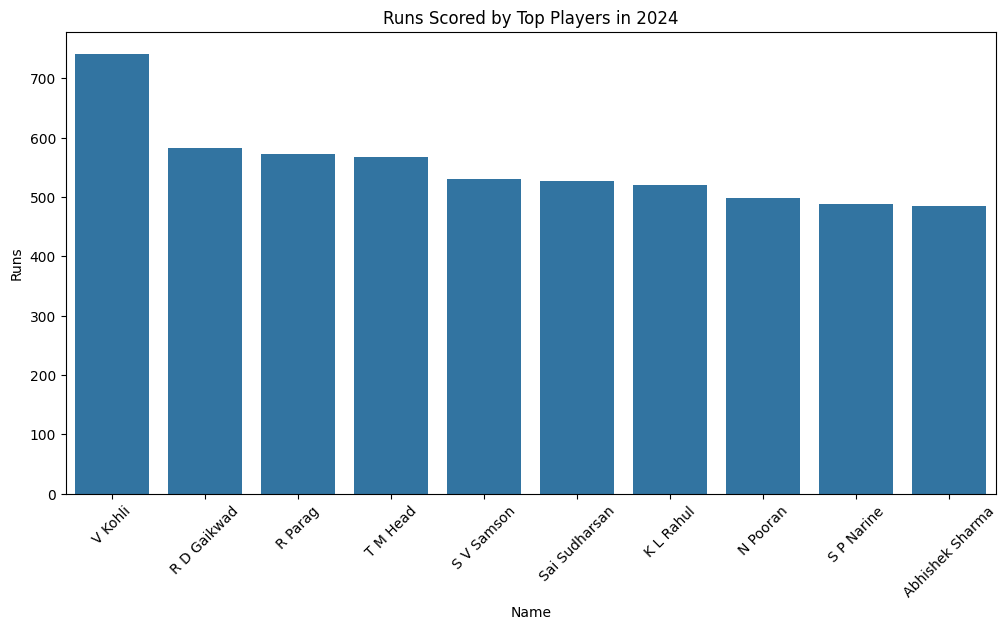

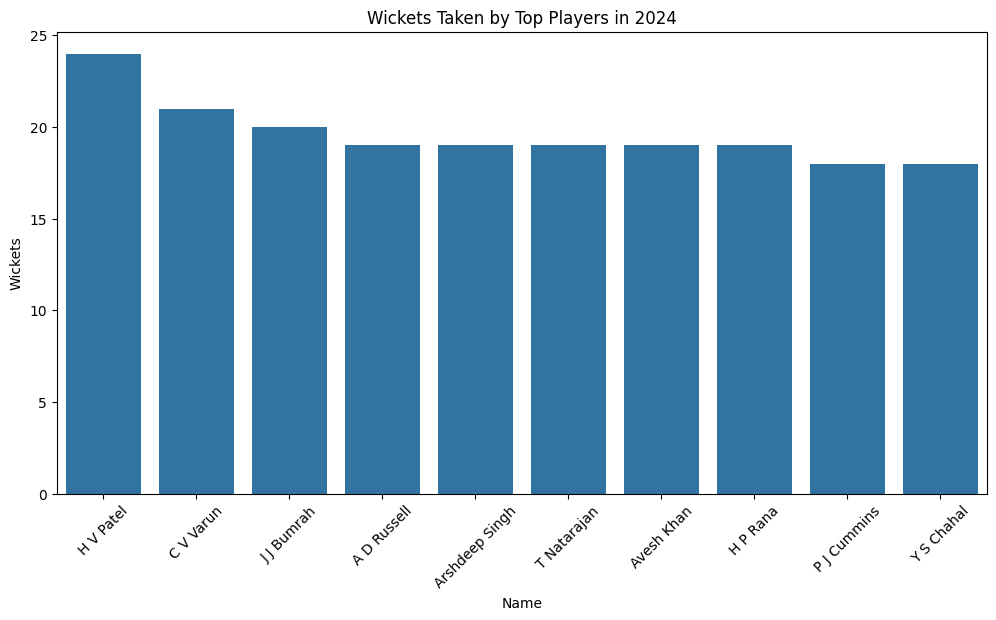

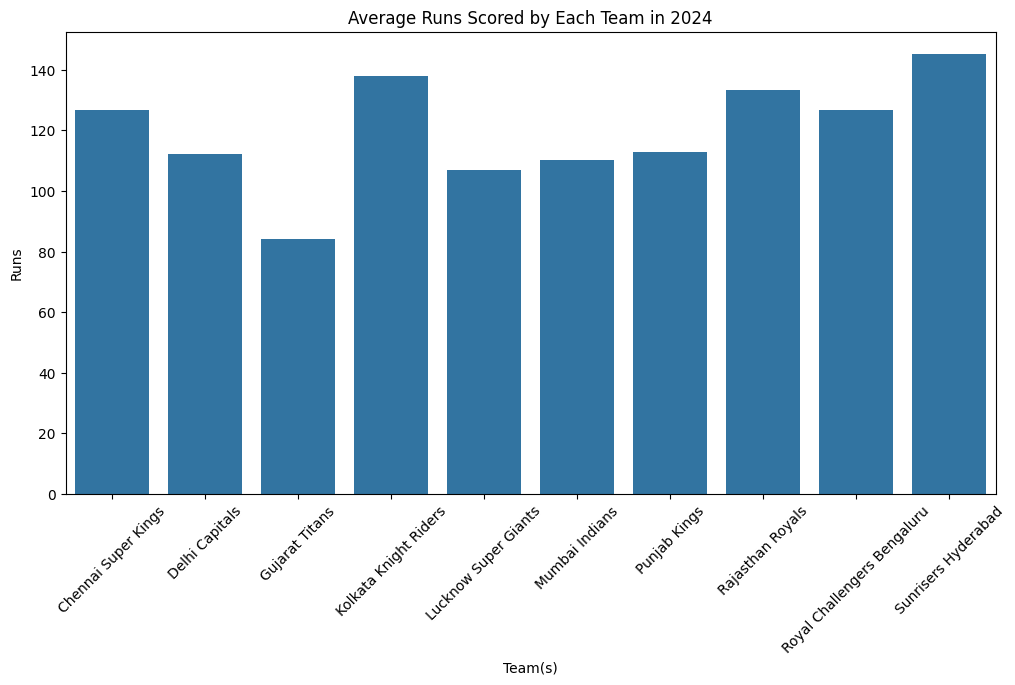

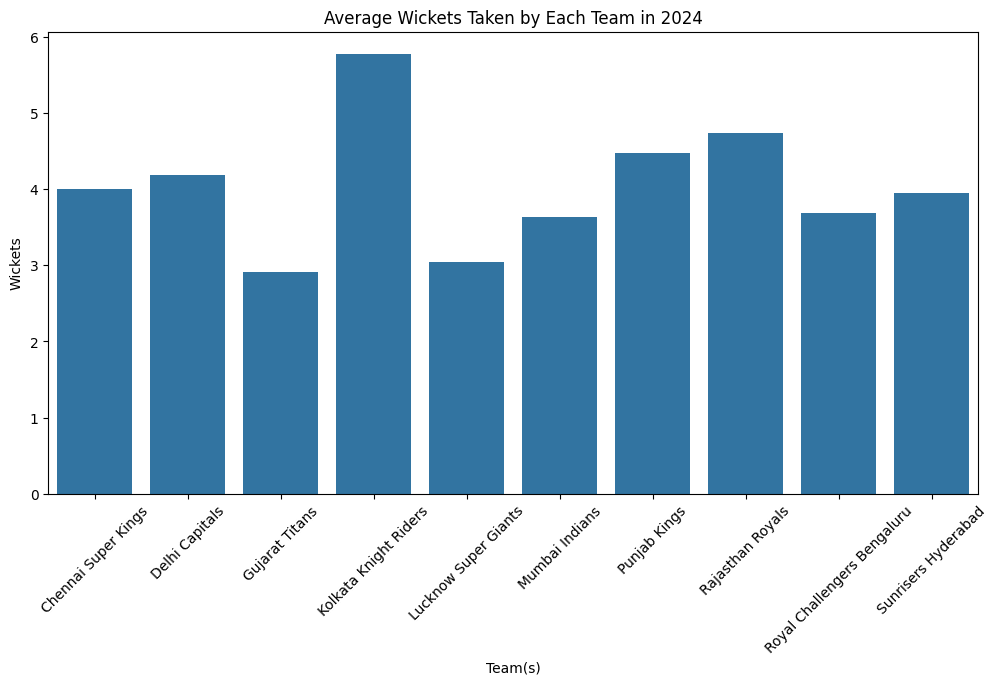

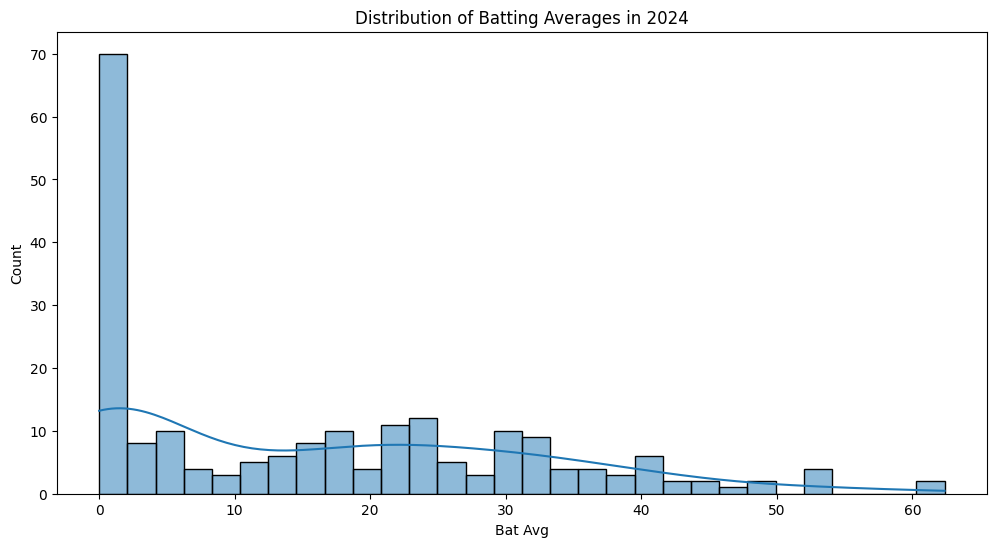

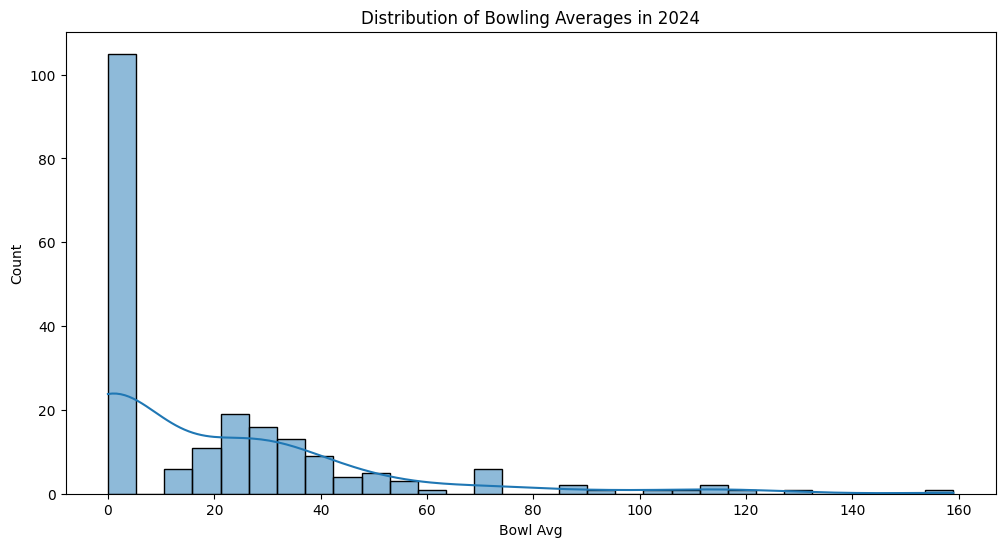

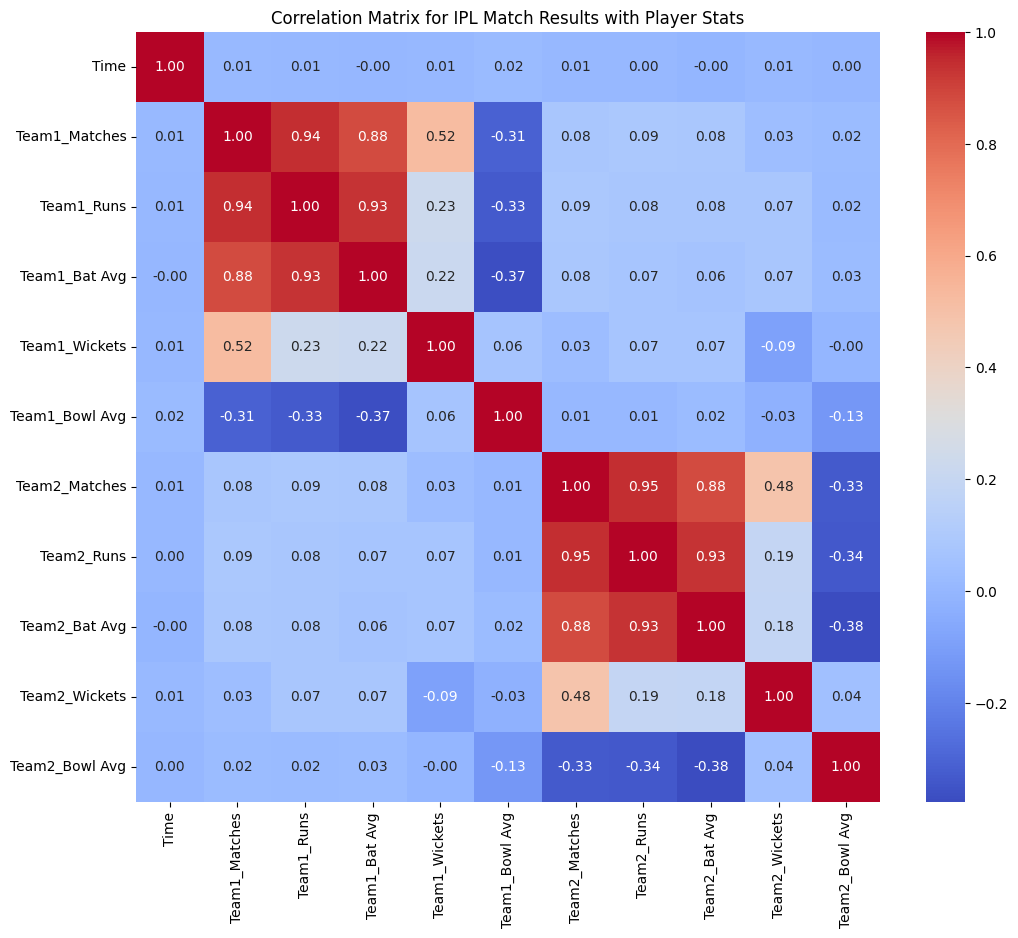

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
ipl_match_results = pd.read_csv("ipl_match_results_cricbuzz_abbreviated_standardized.csv")
player_stats = pd.read_csv("player_stats_standardized.csv")
player_stats_2024 = pd.read_csv("player_stats_2024_standardized.csv")
season_specific_player_stats = pd.read_csv("season_specific_player_stats.csv")
current_players_2024 = pd.read_csv("current_players_2024.csv")
retired_unsold_players = pd.read_csv("retired_unsold_players.csv")
ipl_match_results_with_stats = pd.read_csv("ipl_match_results_with_player_stats.csv")
player_ids = pd.read_csv("player_ids.csv")
player_ids_2024 = pd.read_csv("player_ids_2024.csv")
all_venue_stats = pd.read_csv("all_venue_stats.csv")
all_season_batting_stats = pd.read_csv("all_season_batting_stats.csv")
all_season_bowling_stats = pd.read_csv("all_season_bowling_stats.csv")

# Summary of each dataset
datasets = {
    "IPL Match Results": ipl_match_results,
    "Player Stats": player_stats,
    "Player Stats 2024": player_stats_2024,
    "Season Specific Player Stats": season_specific_player_stats,
    "Current Players 2024": current_players_2024,
    "Retired/Unsold Players": retired_unsold_players,
    "IPL Match Results with Player Stats": ipl_match_results_with_stats,
    "Player IDs": player_ids,
    "Player IDs 2024": player_ids_2024,
    "All Venue Stats": all_venue_stats,
    "All Season Batting Stats": all_season_batting_stats,
    "All Season Bowling Stats": all_season_bowling_stats
}

for name, df in datasets.items():
    print(f"Summary of {name}")
    print(df.describe())
    print("\n")
    print(df.head())
    print("\n")

# Visualizations

# Runs scored by top players in 2024
plt.figure(figsize=(12, 6))
top_batters_2024 = player_stats_2024.nlargest(10, 'Runs')
sns.barplot(x='Name', y='Runs', data=top_batters_2024)
plt.title('Runs Scored by Top Players in 2024')
plt.xticks(rotation=45)
plt.savefig('top_batters_2024.png')
plt.show()

# Wickets taken by top players in 2024
plt.figure(figsize=(12, 6))
top_bowlers_2024 = player_stats_2024.nlargest(10, 'Wickets')
sns.barplot(x='Name', y='Wickets', data=top_bowlers_2024)
plt.title('Wickets Taken by Top Players in 2024')
plt.xticks(rotation=45)
plt.savefig('top_bowlers_2024.png')
plt.show()

# Average runs scored by each team in 2024
plt.figure(figsize=(12, 6))
teamwise_runs_2024 = player_stats_2024.groupby('Team(s)')['Runs'].mean().reset_index()
sns.barplot(x='Team(s)', y='Runs', data=teamwise_runs_2024)
plt.title('Average Runs Scored by Each Team in 2024')
plt.xticks(rotation=45)
plt.savefig('teamwise_runs_2024.png')
plt.show()

# Average wickets taken by each team in 2024
plt.figure(figsize=(12, 6))
teamwise_wickets_2024 = player_stats_2024.groupby('Team(s)')['Wickets'].mean().reset_index()
sns.barplot(x='Team(s)', y='Wickets', data=teamwise_wickets_2024)
plt.title('Average Wickets Taken by Each Team in 2024')
plt.xticks(rotation=45)
plt.savefig('teamwise_wickets_2024.png')
plt.show()

# Distribution of batting averages
plt.figure(figsize=(12, 6))
sns.histplot(player_stats_2024['Bat Avg'].dropna(), kde=True, bins=30)
plt.title('Distribution of Batting Averages in 2024')
plt.savefig('bat_avg_distribution.png')
plt.show()

# Distribution of bowling averages
plt.figure(figsize=(12, 6))
sns.histplot(player_stats_2024['Bowl Avg'].dropna(), kde=True, bins=30)
plt.title('Distribution of Bowling Averages in 2024')
plt.savefig('bowl_avg_distribution.png')
plt.show()

# Correlation Matrix for IPL Match Results with Player Stats
plt.figure(figsize=(12, 10))
correlation_matrix = ipl_match_results_with_stats.select_dtypes(include=[float, int]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for IPL Match Results with Player Stats')
plt.savefig('correlation_matrix_ipl_match_results_with_stats.png')
plt.show()


### Example analysis steps(top players from curent year based on their overall career stats)

In [ ]:
# Load the current players data
current_players_df = pd.read_csv("/content/current_players_2024.csv")

# Extract the set of current player names
current_players_set = set(current_players_df['Name'])

# Load the player stats data
player_stats_df = pd.read_csv("/content/player_stats_standardized.csv")

# Filter for current players
current_players_stats_df = player_stats_df[player_stats_df['Name'].isin(current_players_set)]

# Top 10 batsmen by runs
top_batsmen = current_players_stats_df.nlargest(10, 'Runs')

# Top 10 bowlers by wickets
top_bowlers = current_players_stats_df.nlargest(10, 'Wickets')

print("Top 10 Batsmen(all seasons):")
print(top_batsmen[['Name', 'Runs', 'Bat Avg']])

print("\nTop 10 Bowlers(all seasons):")
print(top_bowlers[['Name', 'Wickets', 'Bowl Avg']])


Top 10 Batsmen(all seasons):
             Name  Runs  Bat Avg
296       V Kohli  8004    38.67
145      S Dhawan  6769    35.26
578    R G Sharma  6628    29.72
708    D A Warner  6565    40.52
146     M S Dhoni  5243    39.13
276   K D Karthik  4842    26.32
489     K L Rahul  4683    45.47
487    A M Rahane  4642    30.14
154  F du Plessis  4571    35.99
538    S V Samson  4419    30.69

Top 10 Bowlers(all seasons):
            Name  Wickets  Bowl Avg
103   Y S Chahal      205     22.45
111   P P Chawla      192     26.60
302      B Kumar      181     27.23
43      R Ashwin      180     29.83
410   S P Narine      180     25.39
371     A Mishra      174     23.84
97    J J Bumrah      165     22.52
245   R A Jadeja      160     30.40
499  Rashid Khan      149     21.83
725    U T Yadav      144     29.83


In [ ]:
import pandas as pd

# Load the match results data
match_results_df = pd.read_csv("/content/ipl_match_results_cricbuzz_abbreviated.csv")

# Define the mapping for team name standardization
team_name_mapping = {
    "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
    "Delhi Daredevils": "Delhi Capitals",
    "Rising Pune Supergiant": "Rising Pune Supergiants",
    "Kings XI Punjab": "Punjab Kings"
}

# Function to replace team names based on the mapping
def standardize_team_name(team_name):
    return team_name_mapping.get(team_name, team_name)

# Extract the winning team from the Result column
def extract_winner(result):
    if "won by" in result:
        return result.split(" won by ")[0]
    else:
        return None

# Apply the function to the Result column to create a new Winner column
match_results_df['Winner'] = match_results_df['Result'].apply(extract_winner)

# Standardize the team names in the Winner column
match_results_df['Winner'] = match_results_df['Winner'].apply(standardize_team_name)

# Save the updated match results to a CSV file
match_results_df.to_csv("/content/ipl_match_results_cricbuzz_abbreviated_standardized.csv", index=False)

# Calculate the number of wins for each team
team_wins = match_results_df['Winner'].value_counts()

print("Team Success Rate:")
print(team_wins)


Team Success Rate:
Winner
Mumbai Indians                 79
Kolkata Knight Riders          77
Sunrisers Hyderabad            72
Chennai Super Kings            69
Royal Challengers Bengaluru    69
Delhi Capitals                 68
Rajasthan Royals               56
Punjab Kings                   54
Gujarat Titans                 28
Lucknow Super Giants           24
Rising Pune Supergiants        15
Gujarat Lions                  13
Name: count, dtype: int64


# Methodology 1: Performance Analysis

### Step 1: Load the Data

In [ ]:
import pandas as pd

# Load current year stats
current_year_stats_df = pd.read_csv("player_stats_2024_standardized.csv")

# Load overall IPL career stats
career_stats_df = pd.read_csv("current_players_2024.csv")


### Step 2: Identify Top-Performing Players

In [ ]:
# Top 10 batsmen based on Batting Average
top_batsmen = current_year_stats_df.nlargest(10, 'Bat Avg')[['Name', 'Bat Avg', 'Runs', 'Matches']]

# Top 10 bowlers based on Wickets
top_bowlers = current_year_stats_df.nlargest(10, 'Wickets')[['Name', 'Wickets', 'Bowl Avg', 'Matches']]

print("Top Batsmen:")
print(top_batsmen)

print("\nTop Bowlers:")
print(top_bowlers)


Top Batsmen:
            Name  Bat Avg  Runs  Matches
0       N Pooran    62.38   499       14
1        V Kohli    61.75   741       15
2       T Stubbs    54.00   378       14
3      M S Dhoni    53.67   161       14
4    R D Gaikwad    53.00   583       14
5        R Parag    52.09   573       16
6     S V Samson    48.27   531       16
7  Sai Sudharsan    47.91   527       12
8       V R Iyer    46.25   370       15
9     R A Jadeja    44.50   267       14

Top Bowlers:
               Name  Wickets  Bowl Avg  Matches
129       H V Patel       24     19.88       14
163       C V Varun       21     19.14       15
166      J J Bumrah       20     16.80       13
37      A D Russell       19     15.53       15
131  Arshdeep Singh       19     26.58       14
155     T Natarajan       19     24.47       14
157      Avesh Khan       19     27.68       16
207        H P Rana       19     20.16       13
71      P J Cummins       18     31.44       16
167      Y S Chahal       18     30.33    

### Step 3: Merge the Data


In [ ]:
# Merge the dataframes on the player name
merged_stats_df = pd.merge(career_stats_df, current_year_stats_df, on='Name', suffixes=('_career', '_2024'))


# Remove the redundant 'Team(s)_2024' column
merged_stats_df.drop(columns=['Team(s)_2024'], inplace=True)

# Display the merged dataframe
print(merged_stats_df.head())


              Name           Team(s)_career  Matches_career  Runs_career  \
0      Abdul Samad                      SUN              50          577   
1  Abhishek Sharma                 DDV, SUN              63         1377   
2      M A Agarwal  RCB, DDV, RPS, KXI, SUN             127         2661   
3        K K Ahmed                 SUN, DDV              57            1   
4       Akash Deep                      RCB               8           19   

   Bat Avg_career  Wickets_career  Bowl Avg_career Current Team_career  \
0           19.23               2            56.50                 SRH   
1           25.50              11            35.36                 SRH   
2           22.74               0             0.00                 SRH   
3            0.20              74            25.42                  DC   
4            9.50               7            45.57                 RCB   

   Matches_2024  Runs_2024  Bat Avg_2024  Wickets_2024  Bowl Avg_2024  \
0            16        18

### Step 4: Analyze and Visualize Data

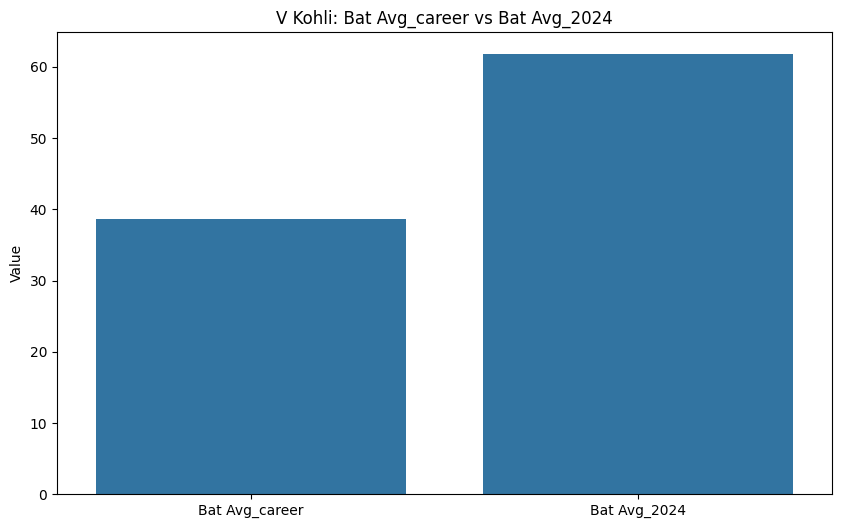

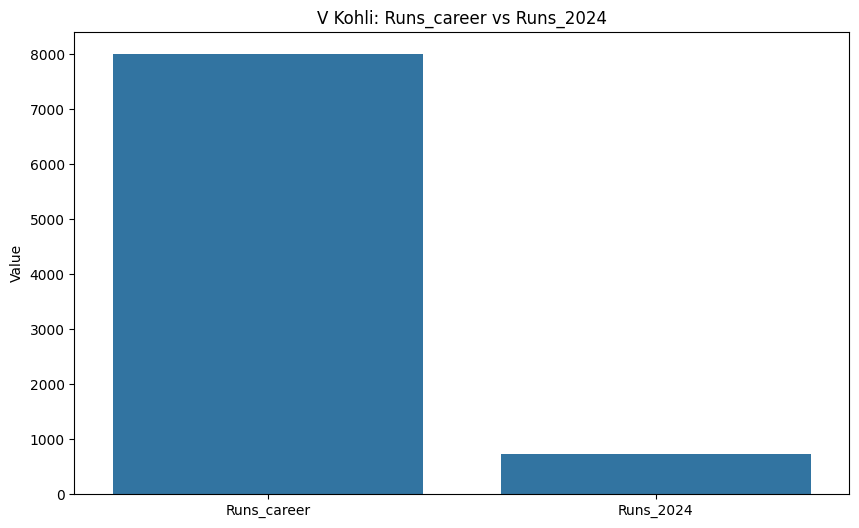

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot comparison between career and current year stats
def plot_performance_comparison(player_name, metric_career, metric_2024):
    player_data = merged_stats_df[merged_stats_df['Name'] == player_name]
    metrics = [metric_career, metric_2024]
    values = [player_data[metric_career].values[0], player_data[metric_2024].values[0]]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics, y=values)
    plt.title(f'{player_name}: {metric_career} vs {metric_2024}')
    plt.ylabel('Value')
    plt.show()

# Example: Comparing Batting Average
plot_performance_comparison('V Kohli', 'Bat Avg_career', 'Bat Avg_2024')

# Example: Comparing Runs
plot_performance_comparison('V Kohli', 'Runs_career', 'Runs_2024')


# Methodology 2: Predictive Modelling

## Predicting Future Matches


Step 1: Merge Player Performance Data


In [ ]:
team_name_mapping = {
    "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
    "Delhi Daredevils": "Delhi Capitals",
    "Kings XI Punjab": "Punjab Kings",
    "Rising Pune Supergiant": "Rising Pune Supergiants"
}
# Load match results data
match_results_df = pd.read_csv("ipl_match_results_cricbuzz_abbreviated.csv")

# Load player performance data
player_stats_df = pd.read_csv("current_players_2024.csv")

def standardize_team_names(team_name):
    return team_name_mapping.get(team_name, team_name)
def simplify_match_details(match_detail):
    teams = match_detail.split(",")[0].strip()
    teams = ' vs '.join([standardize_team_names(team.strip()) for team in teams.split(' vs ')])
    return teams
def time_to_minutes(time_str):
    from datetime import datetime
    time = datetime.strptime(time_str, '%I:%M %p')
    return time.hour * 60 + time.minute

# Merge player performance data with match results
def merge_player_stats(match_df, player_df):
    match_df['Match Details'] = match_df['Match Details'].apply(simplify_match_details)
    match_df['Time'] = match_df['Time'].apply(time_to_minutes)

    # Extract teams from match details
    match_df['Team1'] = match_df['Match Details'].apply(lambda x: x.split(' vs ')[0])
    match_df['Team2'] = match_df['Match Details'].apply(lambda x: x.split(' vs ')[1])

    # Create a function to get aggregated player stats for a team
    def get_team_stats(team, player_df):
        team_players = player_df[player_df['Current Team'] == team]
        return team_players[['Matches', 'Runs', 'Bat Avg', 'Wickets', 'Bowl Avg']].mean().to_dict()

    # Apply the function to both teams in the match
    match_df['Team1_Stats'] = match_df['Team1'].apply(lambda x: get_team_stats(x, player_df))
    match_df['Team2_Stats'] = match_df['Team2'].apply(lambda x: get_team_stats(x, player_df))

    # Expand the stats into separate columns
    team1_stats_df = match_df['Team1_Stats'].apply(pd.Series)
    team2_stats_df = match_df['Team2_Stats'].apply(pd.Series)

    team1_stats_df.columns = ['Team1_' + col for col in team1_stats_df.columns]
    team2_stats_df.columns = ['Team2_' + col for col in team2_stats_df.columns]

    match_df = pd.concat([match_df, team1_stats_df, team2_stats_df], axis=1)

    # Drop the original stats columns
    match_df.drop(columns=['Team1_Stats', 'Team2_Stats', 'Team1', 'Team2'], inplace=True)

    return match_df

# Merge the datasets
match_results_with_stats_df = merge_player_stats(match_results_df, player_stats_df)

# Save the merged dataset
match_results_with_stats_df.to_csv("ipl_match_results_with_player_stats.csv", index=False)

# Display the first few rows of the merged dataset
print(match_results_with_stats_df.head())


  Match Details                                          Venue  \
0     KKR vs MI                          Eden Gardens, Kolkata   
1     CSK vs DC                MA Chidambaram Stadium, Chennai   
2      PK vs RR  Maharashtra Cricket Association Stadium, Pune   
3    CSK vs SRH                MA Chidambaram Stadium, Chennai   
4    KKR vs RCB                          Eden Gardens, Kolkata   

                                      Result  Time  Team1_Matches  \
0        Kolkata Knight Riders won by 7 wkts   870      69.050000   
1           Chennai Super Kings won by 1 run   870      45.777778   
2            Rajasthan Royals won by 26 runs   870      44.800000   
3         Chennai Super Kings won by 45 runs   630      45.777778   
4  Royal Challengers Bangalore won by 3 wkts   870      69.050000   

    Team1_Runs  Team1_Bat Avg  Team1_Wickets  Team1_Bowl Avg  Team2_Matches  \
0  1111.400000        19.5630      30.500000       19.309000      46.210526   
1   652.777778        16.8050 

In [ ]:
import pandas as pd

# Load match results data
match_results_df = pd.read_csv("ipl_match_results_cricbuzz_abbreviated_standardized.csv")

# Load player performance data
player_stats_df = pd.read_csv("season_specific_player_stats.csv")

# Standardize team names in match results
team_name_mapping = {
    "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
    "Delhi Daredevils": "Delhi Capitals",
    "Kings XI Punjab": "Punjab Kings",
    "Rising Pune Supergiant": "Rising Pune Supergiants",
    "Kolkata Knight Riders": "KKR",
    "Mumbai Indians": "MI",
    "Chennai Super Kings": "CSK",
    "Delhi Capitals": "DC",
    "Punjab Kings": "PK",
    "Rajasthan Royals": "RR",
    "Sunrisers Hyderabad": "SRH",
    "Royal Challengers Bengaluru": "RCB",
    "Kings XI Punjab": "KXIP",
    "Delhi Daredevils": "DC",
    "Gujarat Titans": "GT",
    "Lucknow Super Giants": "LSG",
    "Rising Pune Supergiant": "RPS",
    "Gujarat Lions": "GL"
}

# Function to standardize team names
def standardize_team_names(team_name):
    return team_name_mapping.get(team_name, team_name)

# Simplify match details and standardize team names
def simplify_match_details(match_detail):
    teams = match_detail.split(",")[0].strip()
    teams = ' vs '.join([standardize_team_names(team.strip()) for team in teams.split(' vs ')])
    return teams

# Convert time to minutes
def time_to_minutes(time_str):
    from datetime import datetime
    time = datetime.strptime(time_str, '%I:%M %p')
    return time.hour * 60 + time.minute

# Merge player performance data with match results
def merge_player_stats(match_df, player_df):
    match_df['Match Details'] = match_df['Match Details'].apply(simplify_match_details)
    match_df['Time'] = match_df['Time'].apply(time_to_minutes)

    # Extract teams from match details
    match_df['Team1'] = match_df['Match Details'].apply(lambda x: x.split(' vs ')[0])
    match_df['Team2'] = match_df['Match Details'].apply(lambda x: x.split(' vs ')[1])

    # Function to get aggregated player stats for a team
    def get_team_stats(team, player_df):
        team_players = player_df[player_df['Team(s)'].str.contains(team, case=False, na=False)]
        return team_players[['Matches', 'Runs', 'Bat Avg', 'Wickets', 'Bowl Avg']].mean().to_dict()

    # Apply the function to both teams in the match
    match_df['Team1_Stats'] = match_df['Team1'].apply(lambda x: get_team_stats(x, player_df))
    match_df['Team2_Stats'] = match_df['Team2'].apply(lambda x: get_team_stats(x, player_df))

    # Debugging output
    print("Team1 Stats Sample:\n", match_df['Team1_Stats'].head())
    print("Team2 Stats Sample:\n", match_df['Team2_Stats'].head())

    # Expand the stats into separate columns
    team1_stats_df = match_df['Team1_Stats'].apply(pd.Series)
    team2_stats_df = match_df['Team2_Stats'].apply(pd.Series)

    team1_stats_df.columns = ['Team1_' + col for col in team1_stats_df.columns]
    team2_stats_df.columns = ['Team2_' + col for col in team2_stats_df.columns]

    match_df = pd.concat([match_df, team1_stats_df, team2_stats_df], axis=1)

    # Drop the original stats columns
    match_df.drop(columns=['Team1_Stats', 'Team2_Stats', 'Team1', 'Team2'], inplace=True)

    return match_df

# Filter for 2024 season stats and standardize team names in the player stats DataFrame
player_stats_df_2024 = player_stats_df[player_stats_df['Season'] == 2024].copy()
player_stats_df_2024['Team(s)'] = player_stats_df_2024['Team(s)'].apply(lambda x: standardize_team_names(x))

# Debugging output for player stats
print("Player Stats 2024 Sample:\n", player_stats_df_2024.head())

# Merge the datasets
match_results_with_stats_df = merge_player_stats(match_results_df, player_stats_df_2024)

# Save the merged dataset
match_results_with_stats_df.to_csv("ipl_match_results_with_player_stats.csv", index=False)

# Display the first few rows of the merged dataset
print("Merged DataFrame:")
print(match_results_with_stats_df.head())


Player Stats 2024 Sample:
       Season         Name Team(s)  Matches  Runs  Bat Avg  Wickets  Bowl Avg  \
1494    2024     N Pooran     LSG       14   499    62.38        0       0.0   
1495    2024      V Kohli     RCB       15   741    61.75        0       0.0   
1496    2024     T Stubbs      DC       14   378    54.00        3       5.0   
1497    2024    M S Dhoni     CSK       14   161    53.67        0       0.0   
1498    2024  R D Gaikwad     CSK       14   583    53.00        0       0.0   

     Current Team  
1494          LSG  
1495          RCB  
1496           DC  
1497          CSK  
1498          CSK  
Team1 Stats Sample:
 0    {'Matches': 9.833333333333334, 'Runs': 137.833...
1    {'Matches': 8.842105263157896, 'Runs': 126.578...
2    {'Matches': 8.0, 'Runs': 112.95238095238095, '...
3    {'Matches': 8.842105263157896, 'Runs': 126.578...
4    {'Matches': 9.833333333333334, 'Runs': 137.833...
Name: Team1_Stats, dtype: object
Team2 Stats Sample:
 0    {'Matches': 7.590

Step 2: Feature Engineering, Model Training,Preprocess and Predict New Match Data


RandomForest Cross-Validation Accuracy: 0.67 ± 0.03
GradientBoosting Cross-Validation Accuracy: 0.66 ± 0.03
RandomForest Model Accuracy: 0.72
                             precision    recall  f1-score   support

        Chennai Super Kings       0.59      0.62      0.61        16
             Delhi Capitals       0.44      0.47      0.45        15
              Gujarat Lions       1.00      1.00      1.00        11
             Gujarat Titans       0.73      1.00      0.84         8
      Kolkata Knight Riders       0.50      0.58      0.54        12
       Lucknow Super Giants       0.83      0.88      0.86        17
             Mumbai Indians       0.77      0.56      0.65        18
               Punjab Kings       0.61      0.70      0.65        20
           Rajasthan Royals       0.80      0.75      0.77        16
    Rising Pune Supergiants       0.95      1.00      0.98        20
Royal Challengers Bengaluru       0.73      0.62      0.67        13
        Sunrisers Hyderabad  

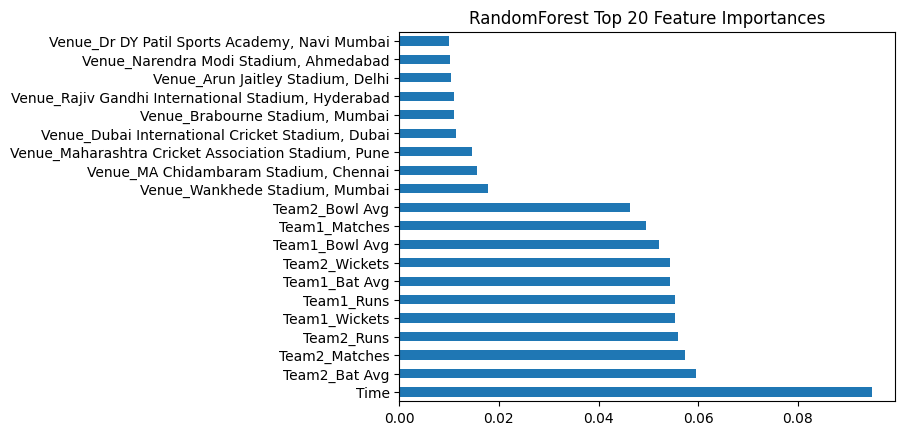

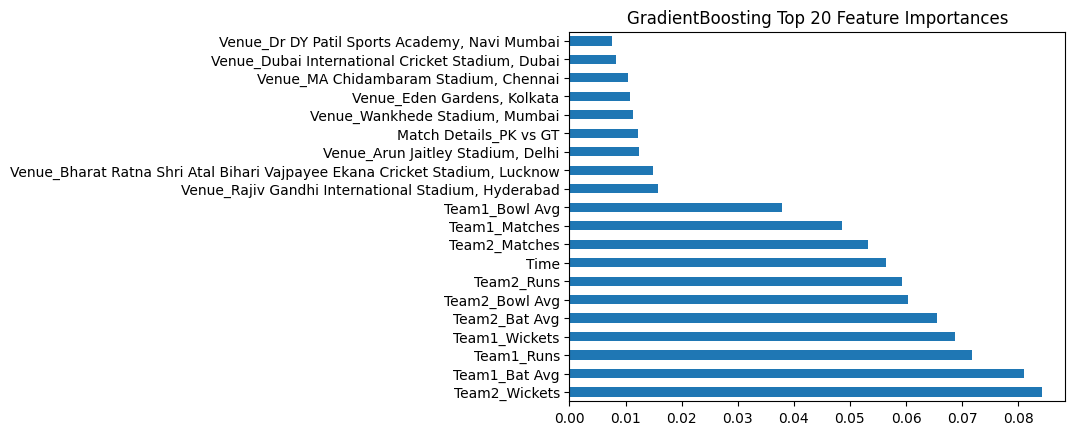

Ensemble Model Accuracy: 0.73
                             precision    recall  f1-score   support

        Chennai Super Kings       0.58      0.69      0.63        16
             Delhi Capitals       0.38      0.40      0.39        15
              Gujarat Lions       1.00      1.00      1.00        11
             Gujarat Titans       0.89      1.00      0.94         8
      Kolkata Knight Riders       0.46      0.50      0.48        12
       Lucknow Super Giants       0.83      0.88      0.86        17
             Mumbai Indians       0.91      0.56      0.69        18
               Punjab Kings       0.68      0.85      0.76        20
           Rajasthan Royals       0.75      0.75      0.75        16
    Rising Pune Supergiants       0.95      1.00      0.98        20
Royal Challengers Bengaluru       0.75      0.69      0.72        13
        Sunrisers Hyderabad       0.74      0.58      0.65        24

                   accuracy                           0.73       190
  

<ipython-input-30-1c5328a814cc>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_match_df[col] = 0
<ipython-input-30-1c5328a814cc>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_match_df[col] = 0
<ipython-input-30-1c5328a814cc>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_match_d

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

team_name_mapping = {
    "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
    "Delhi Daredevils": "Delhi Capitals",
    "Kings XI Punjab": "Punjab Kings",
    "Rising Pune Supergiant": "Rising Pune Supergiants"
}

def standardize_team_names(team_name):
    return team_name_mapping.get(team_name, team_name)
def simplify_match_details(match_detail):
    teams = match_detail.split(",")[0].strip()
    teams = ' vs '.join([standardize_team_names(team.strip()) for team in teams.split(' vs ')])
    return teams
def time_to_minutes(time_str):
    from datetime import datetime
    time = datetime.strptime(time_str, '%I:%M %p')
    return time.hour * 60 + time.minute
def get_team_stats(team, player_df):
    team_players = player_df[player_df['Current Team'] == team]
    if not team_players.empty:
        return team_players[['Matches', 'Runs', 'Bat Avg', 'Wickets', 'Bowl Avg']].mean().to_dict()
    else:
        return {'Matches': 0, 'Runs': 0, 'Bat Avg': 0, 'Wickets': 0, 'Bowl Avg': 0}

def preprocess_new_match_data_with_stats(new_match_df, player_df, reference_columns):
    new_match_df['Time'] = new_match_df['Time'].apply(time_to_minutes)
    new_match_df['Match Details'] = new_match_df['Match Details'].apply(simplify_match_details)

    new_match_df['Team1'] = new_match_df['Match Details'].apply(lambda x: x.split(' vs ')[0])
    new_match_df['Team2'] = new_match_df['Match Details'].apply(lambda x: x.split(' vs ')[1])

    new_match_df['Team1_Stats'] = new_match_df['Team1'].apply(lambda x: get_team_stats(x, player_df))
    new_match_df['Team2_Stats'] = new_match_df['Team2'].apply(lambda x: get_team_stats(x, player_df))

    team1_stats_df = new_match_df['Team1_Stats'].apply(pd.Series)
    team2_stats_df = new_match_df['Team2_Stats'].apply(pd.Series)

    team1_stats_df.columns = ['Team1_' + col for col in team1_stats_df.columns]
    team2_stats_df.columns = ['Team2_' + col for col in team2_stats_df.columns]

    new_match_df = pd.concat([new_match_df, team1_stats_df, team2_stats_df], axis=1)
    new_match_df.drop(columns=['Team1_Stats', 'Team2_Stats', 'Team1', 'Team2'], inplace=True)

    new_match_df = pd.get_dummies(new_match_df, columns=['Match Details', 'Venue'])

    for col in reference_columns:
        if col not in new_match_df.columns:
            new_match_df[col] = 0
    new_match_df = new_match_df[reference_columns]

    return new_match_df

match_results_with_stats_df = pd.read_csv("ipl_match_results_with_player_stats.csv")

def extract_winning_team(result):
    if "won by" in result:
        return standardize_team_names(result.split(" won by ")[0])
    return "Unknown"

match_results_with_stats_df['Winning Team'] = match_results_with_stats_df['Result'].apply(extract_winning_team)
match_results_with_stats_df['Winning Team'] = match_results_with_stats_df['Winning Team'].astype('category')
match_results_with_stats_df = match_results_with_stats_df[match_results_with_stats_df['Winning Team'] != "Unknown"]
match_results_with_stats_df = pd.get_dummies(match_results_with_stats_df, columns=['Match Details', 'Venue'])

X = match_results_with_stats_df.drop(columns=['Result', 'Winning Team'])
y = match_results_with_stats_df['Winning Team']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
print(f'RandomForest Cross-Validation Accuracy: {np.mean(cv_scores_rf):.2f} ± {np.std(cv_scores_rf):.2f}')

model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
cv_scores_gb = cross_val_score(model_gb, X_train, y_train, cv=5)
print(f'GradientBoosting Cross-Validation Accuracy: {np.mean(cv_scores_gb):.2f} ± {np.std(cv_scores_gb):.2f}')

model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'RandomForest Model Accuracy: {accuracy_rf:.2f}')
print(classification_report(y_test, y_pred_rf))

print(f'GradientBoosting Model Accuracy: {accuracy_gb:.2f}')
print(classification_report(y_test, y_pred_gb))


feature_importances_rf = pd.Series(model_rf.feature_importances_, index=X.columns)
feature_importances_gb = pd.Series(model_gb.feature_importances_, index=X.columns)

feature_importances_rf.nlargest(20).plot(kind='barh', title='RandomForest Top 20 Feature Importances')
plt.show()

feature_importances_gb.nlargest(20).plot(kind='barh', title='GradientBoosting Top 20 Feature Importances')
plt.show()


ensemble_model = VotingClassifier(
    estimators=[
        ('rf', model_rf),
        ('gb', model_gb)
    ],
    voting='soft'
)
ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f'Ensemble Model Accuracy: {accuracy_ensemble:.2f}')
print(classification_report(y_test, y_pred_ensemble))


new_match_data = {
    'Match Details': ['RCB vs CSK'],  # Simplified match details without match number
    'Venue': ['Narendra Modi Stadium, Ahmedabad'],  # Replace with actual venue
    'Time': ['02:00 PM']  # Replace with actual time
}
new_match_df = pd.DataFrame(new_match_data)

reference_columns = X.columns

new_match_df_preprocessed = preprocess_new_match_data_with_stats(new_match_df, player_stats_df, reference_columns)

new_match_df_preprocessed = scaler.transform(new_match_df_preprocessed)


predicted_winner_rf = model_rf.predict(new_match_df_preprocessed)
predicted_winner_gb = model_gb.predict(new_match_df_preprocessed)
predicted_winner_ensemble = ensemble_model.predict(new_match_df_preprocessed)

print(f'RandomForest Predicted Winner: {predicted_winner_rf[0]}')
print(f'GradientBoosting Predicted Winner: {predicted_winner_gb[0]}')
print(f'Ensemble Model Predicted Winner: {predicted_winner_ensemble[0]}')


# Methodology 3: Team Performance Evaluation

### Fetching Player Id's of all the players

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# URL of the Howstat.com IPL player list page
url = "https://www.howstat.com/cricket/Statistics/IPL/PlayerList.asp?s=XXXX"

# Function to get player names and IDs from Howstat.com IPL player list page
def fetch_player_ids():
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch data from {url}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table containing player list
    table = soup.find('table', {'class': 'TableLined'})
    if not table:
        print("No player list table found.")
        return None

    rows = table.find_all('tr')[1:]  # Skip the header row
    player_data = []

    for row in rows:
        cols = row.find_all('td')
        if len(cols) < 2:
            continue
        # Extract player name and ID
        player_name = cols[0].text.strip()
        link = cols[0].find('a')
        if link and 'href' in link.attrs:
            player_id = link['href'].split('PlayerID=')[-1]
            player_data.append({'Name': player_name, 'PlayerID': player_id})

    return player_data

# Fetch player data
player_data = fetch_player_ids()

if player_data:
    # Convert to DataFrame
    player_ids_df = pd.DataFrame(player_data)

    # Save the player IDs to a CSV file
    player_ids_df.to_csv('player_ids.csv', index=False)

    # Display the collected player IDs
    print(player_ids_df.head())
else:
    print("No player data found.")


          Name PlayerID
0    V R Aaron     3916
1   K J Abbott     4002
2   S A Abbott     4331
3  Abdul Samad     5863
4  Y A Abdulla     3694


### Load 2024 Players from CSV, Filter Fetched IDs, and Save

In [ ]:
import pandas as pd

# Load the list of 2024 players from an external CSV
player_stats_df = pd.read_csv('player_stats_2024_standardized.csv')
current_players = player_stats_df['Name'].str.strip().tolist()

# Load the fetched player IDs
all_player_ids_df = pd.read_csv('player_ids.csv')

# Filter the fetched player IDs based on the 2024 player list
filtered_player_ids_df = all_player_ids_df[all_player_ids_df['Name'].isin(current_players)]

# Save the filtered player IDs to a CSV file
filtered_player_ids_df.to_csv('player_ids_2024.csv', index=False)

# Display the filtered player IDs
print(filtered_player_ids_df.head())


               Name  PlayerID
3       Abdul Samad      5863
6   Abhishek Sharma      4756
9       M A Agarwal      4104
12        K K Ahmed      4539
13       Akash Deep      6533


### Fetch Venue specific Player Stats using Player ID's

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# Load the player IDs
player_ids_df = pd.read_csv('player_ids_2024.csv')

# Base URL for Howstat.com player stats by venue for IPL
base_url = "http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID="

# Function to fetch venue-specific stats for a player
def fetch_venue_stats(player_id, player_name):
    url = f"{base_url}{player_id}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    print(url)
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch data for player ID {player_id}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table with ground averages
    tables = soup.find_all('table', class_='TableLined')
    ground_averages_table = None
    for table in tables:
        if 'Ground' in table.text:
            ground_averages_table = table
            break

    if ground_averages_table is None:
        print(f"No ground averages table found for player ID {player_id}")
        return None

    # Extract the table data into a DataFrame
    rows = ground_averages_table.find_all('tr')[1:]  # Skip the header row
    data = []
    columns = ['Ground', 'Mat', 'Inns', 'NO', '100s', '50s', 'Ducks', '4s', '6s', 'HS', 'Runs', 'Avg', 'S/R', 'Ca', 'St']
    columns.append('Name')  # Add column for player name

    for row in rows:
        cols = row.find_all('td')
        if len(cols) == 15:  # Ensure the row has the correct number of columns
            row_data = [col.text.strip() for col in cols]
            row_data.append(player_name)  # Add player name to each row
            data.append(row_data)

    if not data:
        print(f"No data found in the ground averages table for player ID {player_id}")
        return None

    df = pd.DataFrame(data, columns=columns)
    return df

# Initialize a DataFrame to collect all players' venue-specific stats
all_venue_stats = pd.DataFrame()

# Iterate over each player in the player_ids_df DataFrame and get their stats
for index, row in player_ids_df.iterrows():
    player_name = row['Name']
    player_id = row['PlayerID']
    print(f"Processing {player_name} with ID {player_id}")
    venue_stats = fetch_venue_stats(player_id, player_name)
    if venue_stats is not None and not venue_stats.empty:
        all_venue_stats = pd.concat([all_venue_stats, venue_stats], ignore_index=True)
    else:
        print(f"No stats found for {player_name}")
    # Sleep to avoid hitting the server too frequently
    time.sleep(1)

# Save the collected venue-specific stats to a CSV file
all_venue_stats.to_csv('all_venue_stats.csv', index=False)

# Display the first few rows of the collected venue-specific stats
print(all_venue_stats.head())


Processing Abdul Samad with ID 5863
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=5863
Processing Abhishek Sharma with ID 4756
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=4756
Processing M A Agarwal with ID 4104
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=4104
Processing K K Ahmed with ID 4539
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=4539
Processing Akash Deep with ID 6533
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=6533
Processing M M Ali with ID 4271
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=4271
Processing Angkrish Raghuvanshi with ID 7757
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=7757
Processing Anmolpreet Singh with ID 4940
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=4940
Processing Anshul Kamboj with ID 7760
http://howstat.com/cricket/statistics/IPL/PlayerGrounds.asp?PlayerID=77

### Scraping Season specific Batting Stats of all the players.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_season_stats(player_id):
    url = f"http://www.howstat.com/cricket/Statistics/IPL/PlayerSeries.asp?PlayerID={player_id}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch data for player ID {player_id}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table with season stats
    table = soup.find('table', {'class': 'TableLined'})

    if not table:
        print(f"No season stats table found for player ID {player_id}")
        return None

    rows = table.find_all('tr')
    data = []

    for row in rows[1:]:  # Skip the header row
        cols = row.find_all('td')
        if len(cols) < 15:
            print(f"Unexpected row format for player ID {player_id}: {row}")
            continue

        try:
            season = cols[0].text.strip()
            matches = int(cols[1].text.strip())
            innings = int(cols[2].text.strip())
            not_outs = int(cols[3].text.strip())
            hundreds = int(cols[4].text.strip())
            fifties = int(cols[5].text.strip())
            ducks = int(cols[6].text.strip())
            fours = int(cols[7].text.strip())
            sixes = int(cols[8].text.strip())
            hs = cols[9].text.strip()
            runs = int(cols[10].text.strip().replace('*', ''))

            # Handle missing Bat Avg and SR by assigning default values
            bat_avg = float(cols[11].text.strip()) if cols[11].text.strip() else 0.0
            sr = float(cols[12].text.strip()) if cols[12].text.strip() else 0.0

            catches = int(cols[13].text.strip()) if cols[13].text.strip() else 0
            stumpings = int(cols[14].text.strip()) if cols[14].text.strip() else 0

            data.append([season, matches, innings, not_outs, hundreds, fifties, ducks, fours, sixes, hs, runs, bat_avg, sr, catches, stumpings])
        except ValueError as e:
            print(f"Error parsing row for player ID {player_id}: {row}")
            print(f"Exception: {e}")
            continue

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Season', 'Matches', 'Innings', 'NO', '100s', '50s', 'Ducks', '4s', '6s', 'HS', 'Runs', 'Bat Avg', 'SR', 'Catches', 'Stumpings'])
    df['PlayerID'] = player_id

    return df

# Load the player IDs from CSV
player_ids_df = pd.read_csv('player_ids_2024.csv')

# Initialize an empty DataFrame to collect all players' season-specific stats
all_season_stats = pd.DataFrame()

for index, row in player_ids_df.iterrows():
    player_name = row['Name']
    player_id = row['PlayerID']
    print(f"Processing {player_name} with ID {player_id}")

    season_stats = get_season_stats(player_id)

    if season_stats is not None:
        season_stats['Name'] = player_name  # Add player name to the DataFrame
        all_season_stats = pd.concat([all_season_stats, season_stats], ignore_index=True)
    else:
        print(f"No stats found for {player_name}")

    # Sleep to avoid hitting the server too frequently
    time.sleep(1)

# Save the aggregated season stats to a CSV file
all_season_stats.to_csv('all_season_batting_stats.csv', index=False)

# Display the first few rows of the aggregated season stats
print(all_season_stats.head())


Processing Abdul Samad with ID 5863
Processing Abhishek Sharma with ID 4756
Processing M A Agarwal with ID 4104
Processing K K Ahmed with ID 4539
Processing Akash Deep with ID 6533
Processing M M Ali with ID 4271
Processing Angkrish Raghuvanshi with ID 7757
Processing Anmolpreet Singh with ID 4940
Processing Anshul Kamboj with ID 7760
Processing Anuj Rawat with ID 5858
Processing V G Arora with ID 5970
Processing Arshdeep Singh with ID 4933
Processing Arshin Kulkarni with ID 7759
Processing Ashutosh Sharma with ID 7764
Processing R Ashwin with ID 3788
Processing Avesh Khan with ID 4673
Processing Azmatullah Omarzai with ID 5936
Processing A Badoni with ID 6538
Processing J M Bairstow with ID 3900
Processing R K Bhui with ID 4409
Processing T A Boult with ID 3924
Processing BR Sharath with ID 7790
Processing D Brevis with ID 6517
Processing J J Bumrah with ID 4062
Processing N Burger with ID 7644
Processing J C Buttler with ID 3888
Processing Y S Chahal with ID 4063
Processing D L Chaha

### Scraping Season specific Bowling Stats of all the players

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_season_bowling_stats(player_id):
    url = f"http://www.howstat.com/cricket/Statistics/IPL/PlayerSeries.asp?PlayerID={player_id}#bowl"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch data for player ID {player_id}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the tables with season stats
    tables = soup.find_all('table', {'class': 'TableLined'})

    if len(tables) < 2:
        print(f"No bowling stats table found for player ID {player_id}")
        return None

    # Assuming the second table is for bowling stats
    bowling_table = tables[1]

    if not bowling_table:
        print(f"No bowling stats table found for player ID {player_id}")
        return None

    rows = bowling_table.find_all('tr')
    data = []

    for row in rows[1:]:  # Skip the header row
        cols = row.find_all('td')
        if len(cols) < 12:
            print(f"Unexpected row format for player ID {player_id}: {row}")
            continue

        try:
            season = cols[0].text.strip()
            matches = int(cols[1].text.strip())
            innings = int(cols[2].text.strip())
            overs = float(cols[3].text.strip())
            maidens = int(cols[4].text.strip())
            runs_conceded = int(cols[5].text.strip())
            wickets = int(cols[6].text.strip())
            four_wickets = int(cols[7].text.strip())
            best_bowling = cols[8].text.strip()

            # Handle missing Avg, SR, and ER by assigning default values
            bowl_avg = float(cols[9].text.strip()) if cols[9].text.strip() else None
            bowl_sr = float(cols[10].text.strip()) if cols[10].text.strip() else None
            er = float(cols[11].text.strip()) if cols[11].text.strip() else None

            data.append([season, matches, innings, overs, maidens, runs_conceded, wickets, four_wickets, best_bowling, bowl_avg, bowl_sr, er])
        except ValueError as e:
            print(f"Error parsing row for player ID {player_id}: {row}")
            print(f"Exception: {e}")
            continue

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Season', 'Matches', 'Innings', 'Overs', 'Maidens', 'Runs Conceded', 'Wickets', '4W', 'Best', 'Bowl Avg', 'Bowl SR', 'ER'])
    df['PlayerID'] = player_id

    return df

# Load the player IDs from CSV
player_ids_df = pd.read_csv('player_ids_2024.csv')

# Initialize an empty DataFrame to collect all players' season-specific stats
all_bowling_stats = pd.DataFrame()

for index, row in player_ids_df.iterrows():
    player_name = row['Name']
    player_id = row['PlayerID']
    print(f"Processing {player_name} with ID {player_id}")

    bowling_stats = get_season_bowling_stats(player_id)

    if bowling_stats is not None:
        bowling_stats['Name'] = player_name  # Add player name to the DataFrame
        all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)
    else:
        print(f"No bowling stats found for {player_name}")

    # Sleep to avoid hitting the server too frequently
    time.sleep(1)

# Save the aggregated bowling stats to a CSV file
all_bowling_stats.to_csv('all_season_bowling_stats.csv', index=False)

# Display the first few rows of the aggregated bowling stats
print(all_bowling_stats.head())


Processing Abdul Samad with ID 5863
Processing Abhishek Sharma with ID 4756
Processing M A Agarwal with ID 4104
No bowling stats table found for player ID 4104
No bowling stats found for M A Agarwal
Processing K K Ahmed with ID 4539
Processing Akash Deep with ID 6533
Processing M M Ali with ID 4271
Processing Angkrish Raghuvanshi with ID 7757
No bowling stats table found for player ID 7757
No bowling stats found for Angkrish Raghuvanshi
Processing Anmolpreet Singh with ID 4940
No bowling stats table found for player ID 4940
No bowling stats found for Anmolpreet Singh
Processing Anshul Kamboj with ID 7760
Processing Anuj Rawat with ID 5858
No bowling stats table found for player ID 5858
No bowling stats found for Anuj Rawat
Processing V G Arora with ID 5970
Processing Arshdeep Singh with ID 4933
Processing Arshin Kulkarni with ID 7759
No bowling stats table found for player ID 7759
No bowling stats found for Arshin Kulkarni
Processing Ashutosh Sharma with ID 7764
No bowling stats table 

<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing S Dube with ID 4945
Processing N Ellis with ID 6082
Processing L H Ferguson with ID 4609
Processing D Ferreira with ID 7214
No bowling stats table found for player ID 7214
No bowling stats found for D Ferreira
Processing J Fraser-McGurk with ID 7679
No bowling stats table found for player ID 7679
No bowling stats found for J Fraser-McGurk
Processing R D Gaikwad with ID 4931
No bowling stats table found for player ID 4931
No bowling stats found for R D Gaikwad
Processing R J Gleeson with ID 6729
Processing S Gopal with ID 4378
Processing K Gowtham with ID 4668
Processing C Green with ID 5926
Processing Gulbadin Naib with ID 3877


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing Harpreet Brar with ID 4935
Processing Harpreet Singh with ID 4077
No bowling stats table found for player ID 4077
No bowling stats found for Harpreet Singh
Processing T M Head with ID 4386
Processing M J Henry with ID 4257
Processing S O Hetmeyer with ID 4681
No bowling stats table found for player ID 4681
No bowling stats found for S O Hetmeyer
Processing D J Hooda with ID 4404
Processing S D Hope with ID 4417
No bowling stats table found for player ID 4417
No bowling stats found for S D Hope
Processing Ishan Kishan with ID 4544
No bowling stats table found for player ID 4544
No bowling stats found for Ishan Kishan
Processing S S Iyer with ID 4387


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing V R Iyer with ID 5971
Processing W G Jacks with ID 6922
Processing R A Jadeja with ID 3644
Processing Y B K Jaiswal with ID 5857


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing M Jansen with ID 5974
Processing S H Johnson with ID 7449
Processing A S Joseph with ID 4575
Processing S Joseph with ID 7657


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing D C Jurel with ID 6541
No bowling stats table found for player ID 6541
No bowling stats found for D C Jurel
Processing K D Karthik with ID 3210
No bowling stats table found for player ID 3210
No bowling stats found for K D Karthik
Processing Kartik Tyagi with ID 5856
Processing V Kaverappa with ID 7206
Processing M A Khan with ID 6521
Processing R S Kishore with ID 5846
Processing H Klaasen with ID 4731
No bowling stats table found for player ID 4731
No bowling stats found for H Klaasen
Processing V Kohli with ID 3600
Processing T K Kotian with ID 7794
No bowling stats table found for player ID 7794
No bowling stats found for T K Kotian
Processing Kuldeep Yadav with ID 4652
Processing B Kumar with ID 3991
Processing M Kumar with ID 7228
Processing Kumar Kushagra with ID 7752
No bowling stats table found for player ID 7752
No bowling stats found for Kumar Kushagra
Processing Lalit Yadav with ID 5848
Processing J B Little with ID 4584
Processing L S Livingstone with ID 4692
Pr

<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing A Manohar with ID 6534
No bowling stats table found for player ID 6534
No bowling stats found for A Manohar
Processing K T Maphaka with ID 7779
Processing M Markande with ID 4772
Processing A K Markram with ID 4701
Processing M R Marsh with ID 3912
Processing G J Maxwell with ID 3969
Processing D A Miller with ID 3783
No bowling stats table found for player ID 3783
No bowling stats found for D A Miller
Processing A Mishra with ID 3108
Processing D J Mitchell with ID 4850
Processing Mohammad Nabi with ID 3665
Processing Mohammed Siraj with ID 4675
Processing Mohsin Khan with ID 4773
Processing Mukesh Choudhary with ID 6507
Processing S Mulani with ID 7223


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing Mustafizur Rahman with ID 4414
Processing D G Nalkande with ID 4936
Processing Naman Dhir with ID 7761


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing S P Narine with ID 3922
Processing T Natarajan with ID 4664
Processing Naveen-ul-Haq with ID 4590
Processing Noor Ahmad with ID 6536
Processing A Nortje with ID 4929
Processing D Padikkal with ID 4948
No bowling stats table found for player ID 4948
No bowling stats found for D Padikkal
Processing M K Pandey with ID 4083
No bowling stats table found for player ID 4083
No bowling stats found for M K Pandey
Processing H H Pandya with ID 4399
Processing K H Pandya with ID 4552
Processing R R Pant with ID 4542
No bowling stats table found for player ID 4542
No bowling stats found for R R Pant
Processing R Parag with ID 4943
Processing A R Patel with ID 4310
Processing H V Patel with ID 4125
Processing M Pathirana with ID 6613
Processing R M Patidar with ID 5980
No bowling stats table found for player ID 5980
No bowling stats found for R M Patidar
Processing N Pooran with ID 4587
No bowling stats table found for player ID 4587
No bowling stats found for N Pooran
Processing A Porel

<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing N K Reddy with ID 7209
Processing J A Richardson with ID 4650
Processing S Rizvi with ID 7749
No bowling stats table found for player ID 7749
No bowling stats found for S Rizvi
Processing R R Rossouw with ID 4321
No bowling stats table found for player ID 4321
No bowling stats found for R R Rossouw
Processing A S Roy with ID 4775
Processing A D Russell with ID 3836
Processing W P Saha with ID 3759
No bowling stats table found for player ID 3759
No bowling stats found for W P Saha
Processing Sai Sudharsan with ID 6535
No bowling stats table found for player ID 6535
No bowling stats found for Sai Sudharsan
Processing P D Salt with ID 6038
No bowling stats table found for player ID 6038
No bowling stats found for P D Salt
Processing S V Samson with ID 4099
No bowling stats table found for player ID 4099
No bowling stats found for S V Samson
Processing Sandeep Sharma with ID 4048
Processing S Sandeep Warrier with ID 4126
Processing M J Santner with ID 4429
Processing Saurav Chau

<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing V Shankar with ID 4027
Processing H Sharma with ID 7220


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing I Sharma with ID 3470
Processing J M Sharma with ID 4554
No bowling stats table found for player ID 4554
No bowling stats found for J M Sharma
Processing K V Sharma with ID 4115
Processing M M Sharma with ID 4028
Processing R G Sharma with ID 3474
Processing S Sharma with ID 7207
Processing P P Shaw with ID 4759
No bowling stats table found for player ID 4759
No bowling stats found for P P Shaw
Processing R Shepherd with ID 5662
Processing Shubham Dubey with ID 7767
No bowling stats table found for player ID 7767
No bowling stats found for Shubham Dubey
Processing Shubman Gill with ID 4769
No bowling stats table found for player ID 4769
No bowling stats found for Shubman Gill
Processing M Siddharth with ID 5852
Processing Sikandar Raza with ID 4022
Processing R Singh with ID 6523
Processing R K Singh with ID 4665
No bowling stats table found for player ID 4665
No bowling stats found for R K Singh
Processing S Singh with ID 4657
Processing S Singh with ID 6509
Processing S Si

<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing Swapnil Singh with ID 4549
Processing A Taide with ID 6525


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing A S Tendulkar with ID 5972
Processing R Tewatia with ID 4379
Processing S N Thakur with ID 4393
Processing Y Thakur with ID 7229
Processing M M Theekshana with ID 6178
Processing I D N Thushara with ID 6475
Processing Tilak Varma with ID 6522


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing Tom Kohler-Cadmore with ID 7768
No bowling stats table found for player ID 7768
No bowling stats found for Tom Kohler-Cadmore
Processing R J W Topley with ID 4479
Processing R A Tripathi with ID 4679


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing A J Turner with ID 4648
No bowling stats table found for player ID 4648
No bowling stats found for A J Turner
Processing Umran Malik with ID 6204
Processing J D Unadkat with ID 3838
Processing C V Varun with ID 4938
Processing Vijayakanth Viyaskanth with ID 7543
Processing Vijaykumar Vyshak with ID 7237
Processing M S Wade with ID 3910
No bowling stats table found for player ID 3910
No bowling stats found for M S Wade
Processing N Wadhera with ID 7224


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing D A Warner with ID 3637


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing Washington Sundar with ID 4684
Processing L B Williams with ID 5984
Processing K S Williamson with ID 3817


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing L Wood with ID 6921
Processing M P Yadav with ID 6540
Processing S A Yadav with ID 4073


<ipython-input-35-2843e2b2cfe4>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bowling_stats = pd.concat([all_bowling_stats, bowling_stats], ignore_index=True)


Processing U T Yadav with ID 3786
Processing Yudhvir Singh with ID 5973
        Season  Matches  Innings  Overs  Maidens  Runs Conceded  Wickets  4W  \
0         2020       12        3    7.0        0             96        1   0   
1         2021       11        1    1.0        0              9        1   0   
2         2022        2        1    1.0        0              8        0   0   
3  Overall (3)       50        5    9.0        0            113        2   0   
4         2019        3        2    2.0        0             21        1   0   

   Best  Bowl Avg  Bowl SR     ER  PlayerID             Name  
0  1/41      96.0     42.0  13.71      5863      Abdul Samad  
1   1/9       9.0      6.0   9.00      5863      Abdul Samad  
2   0/8       NaN      NaN   8.00      5863      Abdul Samad  
3   1/9      56.5     27.0  12.56      5863      Abdul Samad  
4  1/10      21.0     12.0  10.50      4756  Abhishek Sharma  


## Player Impact Analysis

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# Load the season stats
season_batting_stats = pd.read_csv('all_season_batting_stats.csv')
season_bowling_stats = pd.read_csv('all_season_bowling_stats.csv')
player_stats_2024 = pd.read_csv('player_stats_2024_standardized.csv')

# Ensure 'Season' is treated as a string
season_batting_stats['Season'] = season_batting_stats['Season'].astype(str)
season_bowling_stats['Season'] = season_bowling_stats['Season'].astype(str)

# Comprehensive dictionaries for venue and opposition strength multipliers
venue_stats = {
    'Wankhede Stadium': 1.1,
    'Eden Gardens': 1.05,
    'Chinnaswamy Stadium': 1.2,
    'MA Chidambaram Stadium': 0.9,
    'Feroz Shah Kotla Ground': 1.0,
    'Rajiv Gandhi International Stadium': 1.1,
    'Sharjah Cricket Stadium': 1.15,
    'Sawai Mansingh Stadium': 1.0,
    'Dubai International Stadium': 1.0,
    'Punjab Cricket Association IS Bindra Stadium': 0.95,
    'Sheikh Zayed Stadium': 0.95,
    'Barsapara Cricket Stadium': 1.0,
    'Himachal Pradesh Cricket Association Stadium': 1.05,
    'Green Park': 0.9,
    'JSCA International Stadium Complex': 1.0,
    'Maharashtra Cricket Association Stadium': 1.05,
    'Nehru Stadium (Kochi)': 1.0,
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 1.1,
    'Shaheed Veer Narayan Singh International Stadium': 1.0,
    'Holkar Cricket Stadium': 1.05,
    'Brabourne Stadium': 1.0,
    'Vidarbha Cricket Association Stadium': 1.0,
    'Saurashtra Cricket Association Stadium': 1.05,
    'Mangaung Oval': 1.0,
    'Newlands': 1.05,
    'Kingsmead': 1.0,
    'SuperSport Park': 1.1,
    'Wanderers Stadium': 1.15,
    'Buffalo Park': 1.0,
    'Diamond Oval': 1.0,
    "St George's Park": 1.0,
    # Add more venues as needed
}

opposition_strength = {
    'RCB': 1.2,
    'CSK': 1.15,
    'MI': 1.3,
    'SRH': 1.1,
    'KKR': 1.05,
    'DC': 1.1,
    'KXIP': 1.05,
    'RR': 1.0,
    'GT': 1.2,  # Gujarat Titans
    'LSG': 1.15,  # Lucknow Super Giants
    # Add more teams as needed
}

def calculate_player_impact(row, venue_multiplier, opposition_multiplier):
    runs_impact = row.get('Runs', 0) * (1 + venue_multiplier)
    wickets_impact = row.get('Wickets', 0) * (1 + opposition_multiplier)
    return runs_impact + wickets_impact

# Take input from the user
team1 = input("Enter the first team: ").upper()
team2 = input("Enter the second team: ").upper()
venue = input("Enter the venue: ")

# Determine the venue multiplier
venue_multiplier = venue_stats.get(venue, 1)

# Combine batting and bowling data
combined_stats = pd.merge(season_batting_stats, season_bowling_stats, on=['Season', 'PlayerID', 'Name'], how='outer', suffixes=('_bat', '_bowl'))

# Merge with player stats to get current team information
merged_stats = pd.merge(combined_stats, player_stats_2024[['Name', 'Current Team']], on='Name', how='left')

# Filter for the current season (2024)
current_season_stats = merged_stats[merged_stats['Season'] == '2024']

# Filter players from the specific teams
filtered_stats = current_season_stats[current_season_stats['Current Team'].isin([team1, team2])]


# Calculate impact scores for batting and bowling
filtered_stats = filtered_stats.assign(
    Batting_Impact=filtered_stats.apply(
        lambda row: row['Runs'] * (1 + venue_multiplier) if 'Runs' in row else 0, axis=1),
    Bowling_Impact=filtered_stats.apply(
        lambda row: row['Wickets'] * (1 + opposition_strength.get(row['Current Team'], 1)) if 'Wickets' in row else 0, axis=1)
)

# Select top performing batsmen and bowlers
top_batsmen = filtered_stats.nlargest(5, 'Batting_Impact')[['Name', 'Runs', 'Bat Avg', 'Batting_Impact']]
top_bowlers = filtered_stats.nlargest(5, 'Bowling_Impact')[['Name', 'Wickets', 'Bowl Avg', 'Bowling_Impact']]

print("\nTop 5 Batsmen:")
print(top_batsmen)

print("\nTop 5 Bowlers:")
print(top_bowlers)


Enter the first team: rcb
Enter the second team: csk
Enter the venue: wankhede stadium

Top 5 Batsmen:
             Name   Runs  Bat Avg  Batting_Impact
525       V Kohli  741.0    61.75          1482.0
339   R D Gaikwad  583.0    53.00          1166.0
309  F du Plessis  438.0    29.20           876.0
316        S Dube  396.0    36.00           792.0
825   R M Patidar  395.0    30.38           790.0

Top 5 Bowlers:
                  Name  Wickets  Bowl Avg  Bowling_Impact
252      T U Deshpande     17.0     24.94           36.55
235            Y Dayal     15.0     30.60           33.00
675     Mohammed Siraj     15.0     33.07           33.00
692  Mustafizur Rahman     14.0     22.71           30.10
821        M Pathirana     13.0     13.00           27.95


## Prdeciting best probable 15 for a team based on the opposition and venue

In [ ]:
import pandas as pd
import sys

# Load the datasets
player_stats = pd.read_csv('player_stats_2024_standardized.csv')
season_batting_stats = pd.read_csv('all_season_batting_stats.csv')
season_bowling_stats = pd.read_csv('all_season_bowling_stats.csv')

# Ensure 'Season' is treated as a string
season_batting_stats['Season'] = season_batting_stats['Season'].astype(str)
season_bowling_stats['Season'] = season_bowling_stats['Season'].astype(str)

# Filter for the current season (2024)
current_batting_stats = season_batting_stats[season_batting_stats['Season'] == '2024']
current_bowling_stats = season_bowling_stats[season_bowling_stats['Season'] == '2024']

# Combine batting and bowling data for the current season
current_season_stats = pd.merge(current_batting_stats, current_bowling_stats, on=['Season', 'PlayerID', 'Name'], how='outer')

# Merge with player stats to get current team information
merged_stats = pd.merge(current_season_stats, player_stats[['Name', 'Current Team']], on='Name', how='left')

# Define comprehensive dictionaries for venue and opposition strength multipliers
venue_stats = {
    'Wankhede Stadium': 1.1,
    'Eden Gardens': 1.05,
    'Chinnaswamy Stadium': 1.2,
    'MA Chidambaram Stadium': 0.9,
    'Feroz Shah Kotla Ground': 1.0,
    'Rajiv Gandhi International Stadium': 1.1,
    'Sharjah Cricket Stadium': 1.15,
    'Sawai Mansingh Stadium': 1.0,
    'Dubai International Stadium': 1.0,
    'Punjab Cricket Association IS Bindra Stadium': 0.95,
    'Sheikh Zayed Stadium': 0.95,
    'Barsapara Cricket Stadium': 1.0,
    'Himachal Pradesh Cricket Association Stadium': 1.05,
    'Green Park': 0.9,
    'JSCA International Stadium Complex': 1.0,
    'Maharashtra Cricket Association Stadium': 1.05,
    'Nehru Stadium (Kochi)': 1.0,
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 1.1,
    'Shaheed Veer Narayan Singh International Stadium': 1.0,
    'Holkar Cricket Stadium': 1.05,
    'Brabourne Stadium': 1.0,
    'Vidarbha Cricket Association Stadium': 1.0,
    'Saurashtra Cricket Association Stadium': 1.05,
    'Mangaung Oval': 1.0,
    'Newlands': 1.05,
    'Kingsmead': 1.0,
    'SuperSport Park': 1.1,
    'Wanderers Stadium': 1.15,
    'Buffalo Park': 1.0,
    'Diamond Oval': 1.0,
    "St George's Park": 1.0,
    # Add more venues as needed
}

opposition_strength = {
    'RCB': 1.2,
    'CSK': 1.15,
    'MI': 1.3,
    'SRH': 1.1,
    'KKR': 1.05,
    'DC': 1.1,
    'KXIP': 1.05,
    'RR': 1.0,
    'GT': 1.2,  # Gujarat Titans
    'LSG': 1.15,  # Lucknow Super Giants
    # Add more teams as needed
}

def calculate_performance(row):
    batting_points = row['Runs'] * 1 + row['Bat Avg'] * 2 if pd.notnull(row['Runs']) and pd.notnull(row['Bat Avg']) else 0
    bowling_points = row['Wickets'] * 25 + (100 - row['Bowl Avg']) * 2 if pd.notnull(row['Wickets']) and pd.notnull(row['Bowl Avg']) else 0
    return batting_points + bowling_points

merged_stats['Performance'] = merged_stats.apply(calculate_performance, axis=1)

# Aggregate performance by player
aggregated_stats = merged_stats.groupby('Name').agg({
    'Performance': 'sum',
    'Current Team': 'first'
}).reset_index()

def select_best_team(team_name, venue, opposition_team):
    venue_multiplier = venue_stats.get(venue, 1)
    opposition_multiplier = opposition_strength.get(opposition_team, 1)

    team_players = aggregated_stats[aggregated_stats['Current Team'] == team_name]

    team_players['Impact'] = team_players.apply(
        lambda row: row['Performance'] * venue_multiplier * opposition_multiplier, axis=1)

    best_players = team_players.nlargest(15, 'Impact')[['Name', 'Performance', 'Impact']]

    return best_players

def evaluate_team_performance(team_name):
    team_performance = aggregated_stats[aggregated_stats['Current Team'] == team_name]
    total_performance = team_performance['Performance'].sum()
    average_performance = team_performance['Performance'].mean()
    print(f"\nPerformance evaluation for {team_name}:")
    print(f"Total Performance: {total_performance}")
    print(f"Average Performance: {average_performance}")
    print(f"Number of Players: {len(team_performance)}")

team_name = input("Enter the team name: ").upper()
venue = input("Enter the venue: ")
opposition_team = input("Enter the opposition team: ").upper()

if opposition_team == team_name:
    print("Opposition name same as Team name")

else:
  best_team = select_best_team(team_name, venue, opposition_team)
  print(f"\nBest 15 players for {team_name} at {venue} against {opposition_team}:")
  print(best_team)
  evaluate_team_performance(team_name)


Enter the team name: rcb
Enter the venue: wankhede stadium
Enter the opposition team: gt

Best 15 players for RCB at wankhede stadium against GT:
                  Name  Performance    Impact
192            V Kohli       864.50  1037.400
29             C Green       708.16   849.792
105     Mohammed Siraj       532.86   639.432
201            Y Dayal       513.80   616.560
41        F du Plessis       496.40   595.680
136        R M Patidar       455.76   546.912
197          W G Jacks       445.72   534.864
64         K D Karthik       398.44   478.128
178      Swapnil Singh       379.66   455.592
78        L H Ferguson       371.34   445.608
43         G J Maxwell       370.56   444.672
73          K V Sharma       354.08   424.896
196  Vijaykumar Vyshak       232.00   278.400
133       R J W Topley       219.00   262.800
89          M K Lomror       156.26   187.512

Performance evaluation for RCB:
Total Performance: 6844.540000000001
Average Performance: 311.1154545454546
Number of

<ipython-input-37-b5ef3253bd28>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['Impact'] = team_players.apply(


### Fantasy team selection

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# Load the main player statistics
player_stats = pd.read_csv('player_stats_2024_standardized.csv')

# Load the venue-specific performance data
venue_stats = pd.read_csv('all_venue_stats.csv')

# Function to calculate fantasy points
def calculate_fantasy_points(row):
    try:
        points = 0
        # Batting points
        points += row.get('Runs', 0)
        points += 4 if row.get('Runs', 0) >= 30 else 0
        points += 8 if row.get('Runs', 0) >= 50 else 0
        points += 16 if row.get('Runs', 0) >= 100 else 0
        points += -2 if row.get('Runs', 0) == 0 else 0

        # Bowling points
        points += row.get('Wickets', 0) * 25
        points += 4 if row.get('Wickets', 0) >= 3 else 0
        points += 8 if row.get('Wickets', 0) >= 4 else 0
        points += 16 if row.get('Wickets', 0) >= 5 else 0

        # Venue-specific performance (if available)
        if pd.notnull(row.get('Runs_venue')):
            points += row.get('Runs_venue', 0) * 0.1
        if pd.notnull(row.get('Wickets_venue')):
            points += row.get('Wickets_venue', 0) * 2

        return points
    except Exception as e:
        print(f"Error calculating fantasy points for row: {row}\nError: {e}")
        return 0

# Aggregate venue-specific performance data for each player and venue
venue_agg_stats = venue_stats.groupby(['Name', 'Ground']).agg(
    Runs_venue=pd.NamedAgg(column='Runs', aggfunc='sum'),
    Wickets_venue=pd.NamedAgg(column='Mat', aggfunc='sum')
).reset_index()

# Merge the venue stats with the main player stats
player_stats = pd.merge(player_stats, venue_agg_stats, on='Name', how='left')

# Apply the function to calculate fantasy points
player_stats['Fantasy Points'] = player_stats.apply(calculate_fantasy_points, axis=1)

# Define player roles based on the dataset
def assign_role(row):
    if row.get('Wickets', 0) > 0 and row.get('Runs', 0) > 100:
        return 'AR'  # All Rounder
    elif row.get('Wickets', 0) > 0:
        return 'BWL'  # Bowler
    elif row.get('Runs', 0) > 0:
        return 'BAT'  # Batsman
    else:
        return 'WK'  # Wicket Keeper

player_stats['Role'] = player_stats.apply(assign_role, axis=1)

# Function to select the best team for a specific match and venue
def select_best_team(player_stats, team1, team2, venue):
    try:
        venue_players = player_stats[(player_stats['Ground'] == venue) & (player_stats['Current Team'].isin([team1, team2]))]
        match_players = venue_players[venue_players['Fantasy Points'] > 0]

        wk = match_players[match_players['Role'] == 'WK'].nlargest(4, 'Fantasy Points')
        bat = match_players[match_players['Role'] == 'BAT'].nlargest(6, 'Fantasy Points')
        ar = match_players[match_players['Role'] == 'AR'].nlargest(4, 'Fantasy Points')
        bwl = match_players[match_players['Role'] == 'BWL'].nlargest(6, 'Fantasy Points')

        selected_wk = wk.head(1) if not wk.empty else pd.DataFrame()
        selected_bat = bat.head(3) if not bat.empty else pd.DataFrame()
        selected_ar = ar.head(1) if not ar.empty else pd.DataFrame()
        selected_bwl = bwl.head(3) if not bwl.empty else pd.DataFrame()

        remaining_players = pd.concat([wk.iloc[1:], bat.iloc[3:], ar.iloc[1:], bwl.iloc[3:]])
        remaining_players = remaining_players.nlargest(11 - len(selected_wk) - len(selected_bat) - len(selected_ar) - len(selected_bwl), 'Fantasy Points')

        best_team = pd.concat([selected_wk, selected_bat, selected_ar, selected_bwl, remaining_players])

        return best_team
    except Exception as e:
        print(f"Error selecting best team for {team1} vs {team2} at {venue}\nError: {e}")
        return pd.DataFrame()

# Specify the teams involved in the match and the venue
team1 = 'RCB'
team2 = 'GT'
venue = 'Narendra Modi Stadium'

# Get the best team for the specific match and venue
best_team = select_best_team(player_stats, team1, team2, venue)

# Display the recommended players
print(best_team[['Name', 'Role', 'Fantasy Points', 'Runs', 'Wickets', 'Bat Avg', 'Bowl Avg', 'Ground']])


                Name Role  Fantasy Points  Runs  Wickets  Bat Avg  Bowl Avg  \
29           V Kohli  BAT           802.9   741        0    61.75      0.00   
149    Sai Sudharsan  BAT           639.3   527        0    47.91      0.00   
368     Shubman Gill  BAT           585.3   426        0    38.73      0.00   
645          C Green   AR           578.0   255       10    31.88     30.30   
1798  Mohammed Siraj  BWL           425.0    12       15     6.00     33.07   
2541         Y Dayal  BWL           413.0     0       15     0.00     30.60   
2080      M M Sharma  BWL           383.2     2       13     1.00     32.69   
830     F du Plessis  BAT           480.7   438        0    29.20      0.00   
748      R M Patidar  BAT           448.4   395        0    30.38      0.00   
1252     Rashid Khan   AR           445.6   102       10    20.40     36.70   
435      K D Karthik  BAT           372.6   326        0    36.22      0.00   

                     Ground  
29    Narendra Modi S

### Time-Series Analysis based on Player ID

Enter Player Id:3600


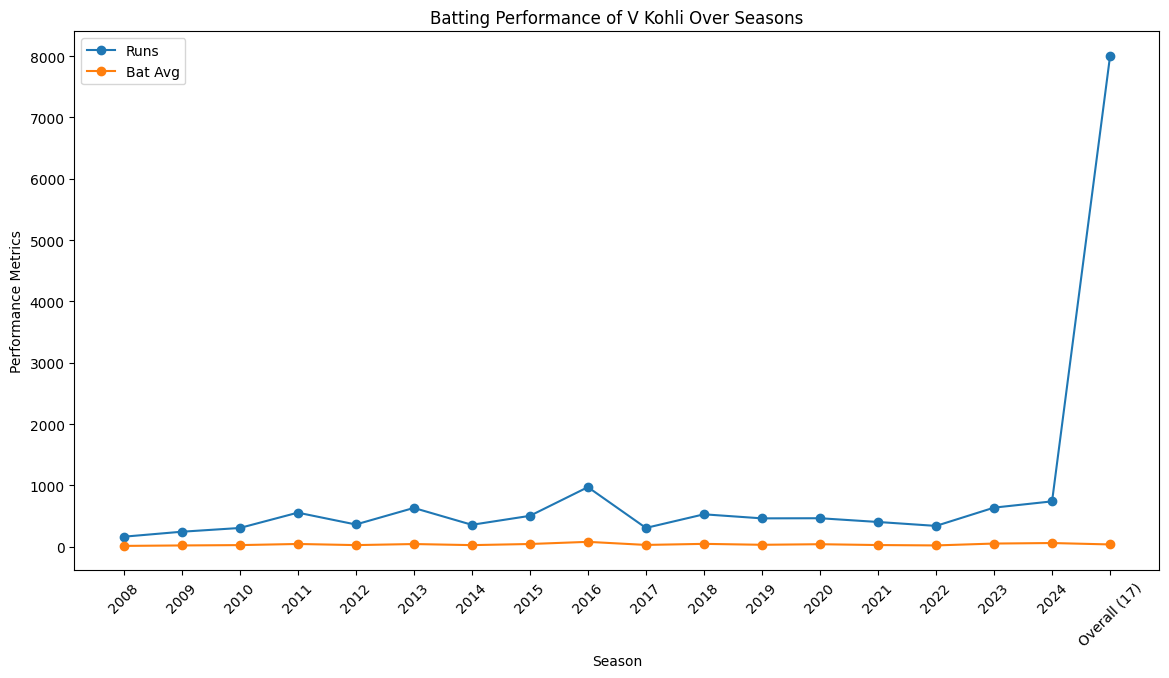

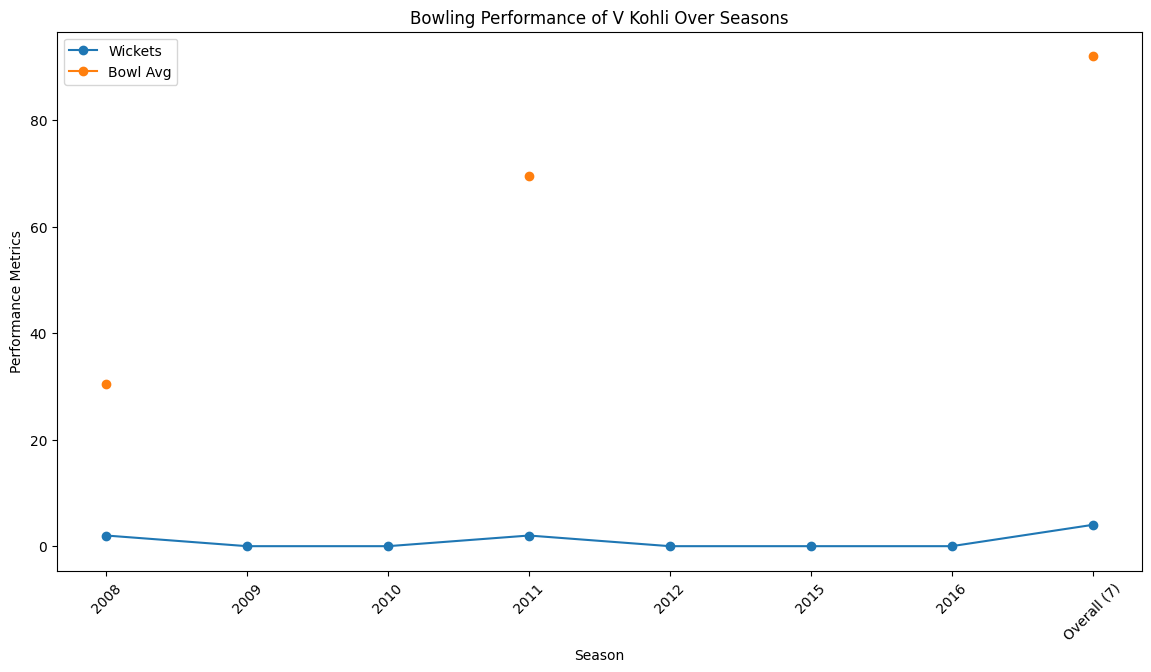

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the season stats
season_batting_stats = pd.read_csv('all_season_batting_stats.csv')
season_bowling_stats = pd.read_csv('all_season_bowling_stats.csv')

# Ensure 'Season' is treated as a string
season_batting_stats['Season'] = season_batting_stats['Season'].astype(str)
season_bowling_stats['Season'] = season_bowling_stats['Season'].astype(str)

# Filter data for a specific player using PlayerID, e.g., PlayerID for Abdul Samad
player_id = int(input("Enter Player Id:"))
player_name = season_batting_stats[season_batting_stats['PlayerID'] == player_id]['Name'].iloc[0]  # Get player name for title

player_batting_stats = season_batting_stats[season_batting_stats['PlayerID'] == player_id]
player_bowling_stats = season_bowling_stats[season_bowling_stats['PlayerID'] == player_id]

# Check if the data for the player is present
if player_batting_stats.empty:
    print(f"No batting stats found for player ID {player_id}")
else:
    # Plot batting performance over seasons
    plt.figure(figsize=(14, 7))
    plt.plot(player_batting_stats['Season'], player_batting_stats['Runs'], marker='o', label='Runs')
    plt.plot(player_batting_stats['Season'], player_batting_stats['Bat Avg'], marker='o', label='Bat Avg')
    plt.title(f'Batting Performance of {player_name} Over Seasons')
    plt.xlabel('Season')
    plt.ylabel('Performance Metrics')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Check if the data for the player is present
if player_bowling_stats.empty:
    print(f"No bowling stats found for player ID {player_id}")
else:
    # Plot bowling performance over seasons
    plt.figure(figsize=(14, 7))
    plt.plot(player_bowling_stats['Season'], player_bowling_stats['Wickets'], marker='o', label='Wickets')
    plt.plot(player_bowling_stats['Season'], player_bowling_stats['Bowl Avg'], marker='o', label='Bowl Avg')
    plt.title(f'Bowling Performance of {player_name} Over Seasons')
    plt.xlabel('Season')
    plt.ylabel('Performance Metrics')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


# Visualisation Techniques included in the report

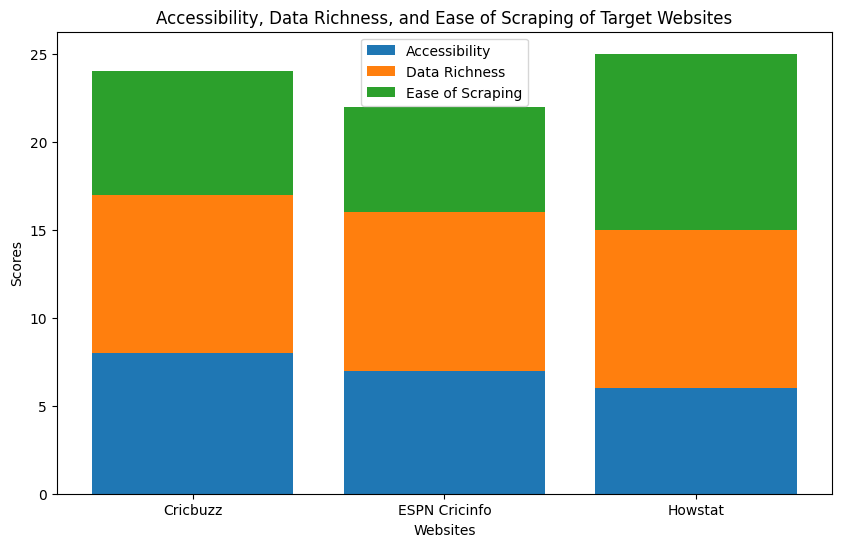

In [ ]:
import matplotlib.pyplot as plt

# Replace these with actual website names
websites = ['Cricbuzz', 'ESPN Cricinfo', 'Howstat']
accessibility = [8, 7, 6]  # Adjusted scores for accessibility
data_richness = [9, 9, 9]  # Adjusted scores for data richness
ease_of_scraping = [7, 6, 10]  # New criterion for ease of scraping

# Calculate the combined scores by summing up the three criteria
combined_scores = [a + d + e for a, d, e in zip(accessibility, data_richness, ease_of_scraping)]

plt.figure(figsize=(10, 6))
plt.bar(websites, accessibility, label='Accessibility')
plt.bar(websites, data_richness, bottom=accessibility, label='Data Richness')
plt.bar(websites, ease_of_scraping, bottom=[a + d for a, d in zip(accessibility, data_richness)], label='Ease of Scraping')
plt.xlabel('Websites')
plt.ylabel('Scores')
plt.title('Accessibility, Data Richness, and Ease of Scraping of Target Websites')
plt.legend()
plt.show()


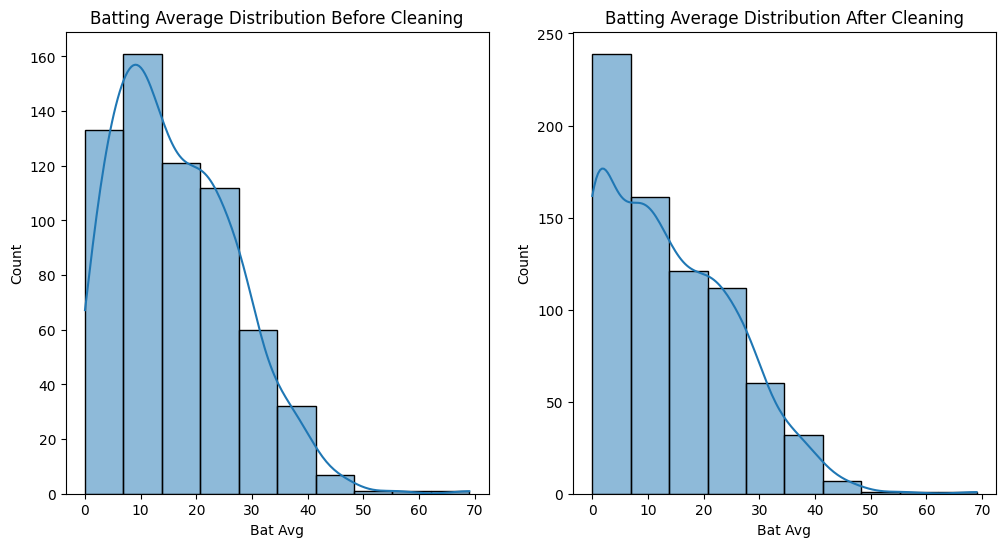

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets before and after cleaning
df_before = pd.read_csv("player_stats.csv")
df_after = pd.read_csv("player_stats_imputed.csv")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_before['Bat Avg'], bins=10, kde=True)
plt.title('Batting Average Distribution Before Cleaning')

plt.subplot(1, 2, 2)
sns.histplot(df_after['Bat Avg'], bins=10, kde=True)
plt.title('Batting Average Distribution After Cleaning')
plt.show()


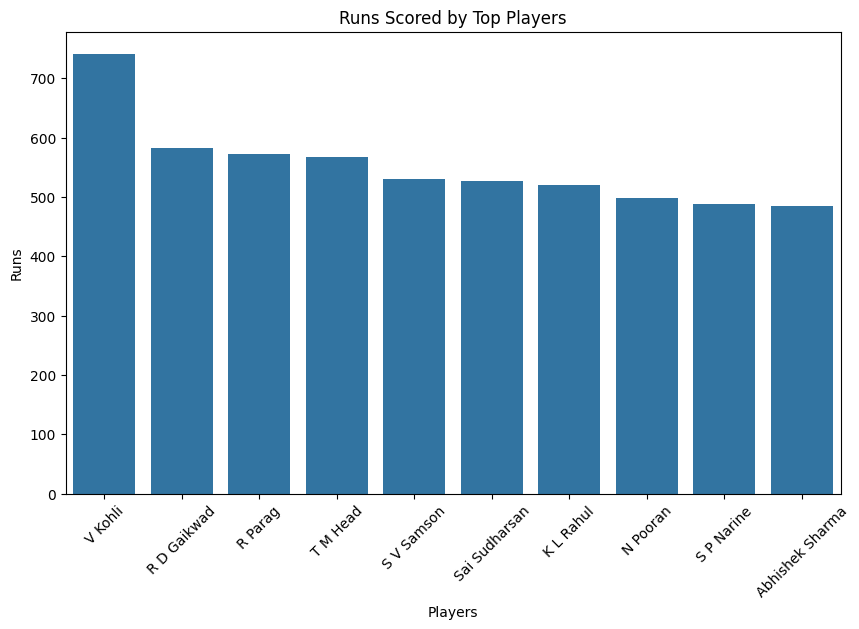

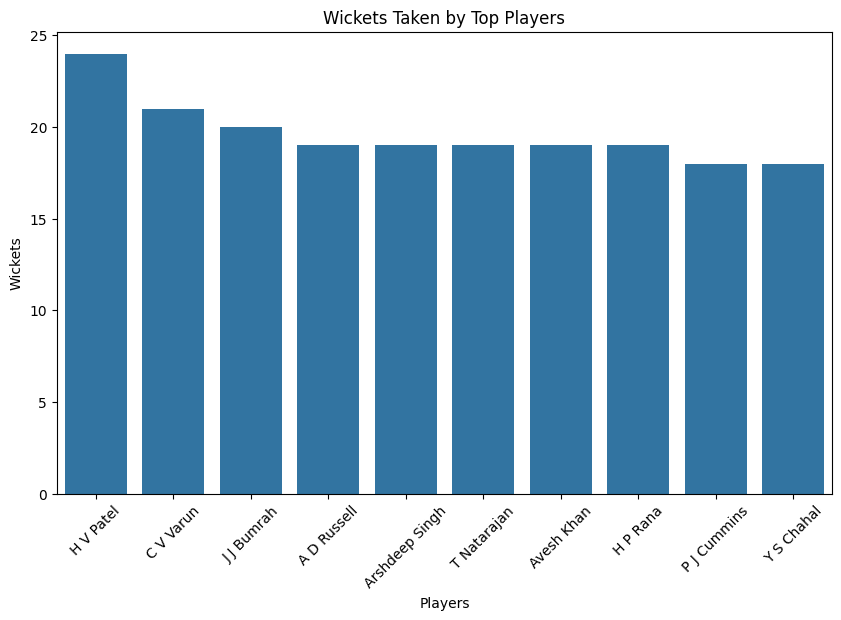

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your actual player performance data
player_performance_df = pd.read_csv("player_stats_2024_standardized.csv")

# Select the top players based on runs scored
top_players = player_performance_df.nlargest(10, 'Runs')

plt.figure(figsize=(10, 6))
sns.barplot(x=top_players['Name'], y=top_players['Runs'])
plt.title('Runs Scored by Top Players')
plt.xlabel('Players')
plt.ylabel('Runs')
plt.xticks(rotation=45)
plt.show()


# Select the top players based on Wickets taken
top_players = player_performance_df.nlargest(10, 'Wickets')

plt.figure(figsize=(10, 6))
sns.barplot(x=top_players['Name'], y=top_players['Wickets'])
plt.title('Wickets Taken by Top Players')
plt.xlabel('Players')
plt.ylabel('Wickets')
plt.xticks(rotation=45)
plt.show()
